In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [12]:
import os
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import itertools
from lendingclub import config
import j_utils.munging as mg
import matplotlib.pyplot as plt
from IPython.display import Image
import pathlib
from sqlalchemy import create_engine


pd.set_option('max_columns', 999)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(threshold=np.inf)

# Compare loan info I collected from api vs the csvs about loan info and pmt_history

In [35]:
# load in my database loans
disk_engine = create_engine(f'sqlite:///{config.lc_api_db}')
db_df = pd.read_sql('lc_api_loans',
                 con=disk_engine,
                 parse_dates=[
                     'accept_d', 'exp_d', 'list_d', 'credit_pull_d',
                     'review_status_d', 'ils_exp_d', 'last_seen_list_d'
                 ])
# hist_df = pd.read_feather(
#     os.path.join(config.data_dir, 'raw_loan_info.fth'))
# pmt_hist_df = pd.read_csv(
#     os.path.join(config.wrk_csv_dir, 'PMTHIST_ALL_201912.csv')
# )
pmt_hist_df = pd.read_feather(
    os.path.join(config.data_dir, 'clean_pmt_history.fth')
)

In [36]:
db_df_ids = db_df.id.values

In [38]:
pmt_hist_df.query('loan_id in @db_df_ids')

,pmt_date,status_period_end,date,issue_d,addr_state,home_ownership,first_credit_line,emp_len,grade,vintage,outs_princp_beg,amt_due,outs_princp_end,m_on_books,int_rate,monthly_pmt,dti,m_income,open_credit_lines,total_credit_lines,revol_line_util,inq_6m,dq_24m,m_since_dq,public_recs,m_since_rec,current_policy,term,fico_apply,fico_last,loan_id,revol_credit_bal,princp_paid,int_paid,fee_paid,amt_paid,charged_off_this_month,charged_off_amt,recovs,recov_fees,all_cash_to_inv


In [39]:
pmt_hist_df.issue_d.max()

Timestamp('2019-09-01 00:00:00')

# examining loading in 04_clean_pmt_hist

In [3]:
csv_path = config.wrk_csv_dir
# for now its always been one csv. Will have to revisit if they break it out to multiple
pmt_hist_fnames = [f for f in os.listdir(csv_path) if 'PMTHIST' in f]
if len(pmt_hist_fnames) > 1:
    sys.exit('more than one payment history file, need to change this code')

# load in dev_ids.pkl and pmt_hist_skiprows
with open(os.path.join(config.data_dir, 'dev_ids.pkl'), "rb") as f:
    dev_ids = pickle.load(f)
with open(os.path.join(config.data_dir, 'pmt_hist_skiprows.pkl'), "rb") as f:
    pmt_hist_skiprows = pickle.load(f)

print('loading pmt_hist; skipping {0} rows'.format(len(pmt_hist_skiprows)))
pmt_hist = pd.read_csv(os.path.join(csv_path, pmt_hist_fnames[0]), skiprows=pmt_hist_skiprows)
print(pmt_hist.columns)

loading pmt_hist; skipping 50282327 rows
Index(['LOAN_ID', 'PBAL_BEG_PERIOD', 'PRNCP_PAID', 'INT_PAID', 'FEE_PAID',
       'DUE_AMT', 'RECEIVED_AMT', 'RECEIVED_D', 'PERIOD_END_LSTAT', 'MONTH',
       'PBAL_END_PERIOD', 'MOB', 'CO', 'COAMT', 'InterestRate', 'IssuedDate',
       'MONTHLYCONTRACTAMT', 'dti', 'State', 'HomeOwnership', 'MonthlyIncome',
       'EarliestCREDITLine', 'OpenCREDITLines', 'TotalCREDITLines',
       'RevolvingCREDITBalance', 'RevolvingLineUtilization', 'Inquiries6M',
       'DQ2yrs', 'MonthsSinceDQ', 'PublicRec', 'MonthsSinceLastRec',
       'EmploymentLength', 'currentpolicy', 'grade', 'term', 'APPL_FICO_BAND',
       'Last_FICO_BAND', 'VINTAGE', 'PCO_RECOVERY', 'PCO_COLLECTION_FEE'],
      dtype='object')


/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pmt_hist.head()

,LOAN_ID,PBAL_BEG_PERIOD,PRNCP_PAID,INT_PAID,FEE_PAID,DUE_AMT,RECEIVED_AMT,RECEIVED_D,PERIOD_END_LSTAT,MONTH,PBAL_END_PERIOD,MOB,CO,COAMT,InterestRate,IssuedDate,MONTHLYCONTRACTAMT,dti,State,HomeOwnership,MonthlyIncome,EarliestCREDITLine,OpenCREDITLines,TotalCREDITLines,RevolvingCREDITBalance,RevolvingLineUtilization,Inquiries6M,DQ2yrs,MonthsSinceDQ,PublicRec,MonthsSinceLastRec,EmploymentLength,currentpolicy,grade,term,APPL_FICO_BAND,Last_FICO_BAND,VINTAGE,PCO_RECOVERY,PCO_COLLECTION_FEE
0,114408,5766.546385,0.000000,0.000000,0.0,1535.56,0.00,NaN,Charged Off,JUN2009,5766.546385,22,1,5766.546385,0.1691,AUG2007,284.86,20.22,FL,OWN,5000.000000,JUL1990,5,23,6755,0.993,1,0,33.0,0,0.0,10+ years,0,G,36,645-649,LOW-499,07Q3,0.55,0.0
1,114469,13000.000000,278.339083,186.600917,0.0,464.95,464.94,SEP2007,Current,SEP2007,12721.660917,1,0,0.000000,0.1722,AUG2007,464.95,15.98,FL,RENT,2666.666667,MAY2005,6,7,6703,0.798,1,0,0.0,0,0.0,1 year,0,G,36,640-644,640-644,07Q3,NaN,NaN
2,114469,12721.660917,282.334339,182.605661,0.0,464.95,464.94,OCT2007,Current,OCT2007,12439.326577,2,0,0.000000,0.1722,AUG2007,464.95,15.98,FL,RENT,2666.666667,MAY2005,6,7,6703,0.798,1,0,0.0,0,0.0,1 year,0,G,36,640-644,MISSING,07Q3,NaN,NaN
3,114469,12439.326577,286.386943,178.553057,0.0,464.95,464.94,NOV2007,Current,NOV2007,12152.939634,3,0,0.000000,0.1722,AUG2007,464.95,15.98,FL,RENT,2666.666667,MAY2005,6,7,6703,0.798,1,0,0.0,0,0.0,1 year,0,G,36,640-644,MISSING,07Q3,NaN,NaN
4,114469,12152.939634,290.497717,174.442283,0.0,464.95,464.94,DEC2007,Current,DEC2007,11862.441917,4,0,0.000000,0.1722,AUG2007,464.95,15.98,FL,RENT,2666.666667,MAY2005,6,7,6703,0.798,1,0,0.0,0,0.0,1 year,0,G,36,640-644,MISSING,07Q3,NaN,NaN


# make tests for detect_strange_pmt_hist

In [263]:
# %load ../lendingclub/csv_preparation/04_clean_pmt_history.py
'''
Reads in payment history, does lots of cleaning
'''
import os
import pickle
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm

import j_utils.munging as mg
from lendingclub import config
import lendingclub.csv_preparation.clean_pmt_history as cph


if __name__ == '__main__':
    # LOADING
    csv_path = config.wrk_csv_dir
    # for now its always been one csv. Will have to revisit if they break it out to multiple
    pmt_hist_fnames = [f for f in os.listdir(csv_path) if 'PMTHIST' in f]
    if len(pmt_hist_fnames) > 1:
        sys.exit('more than one payment history file, need to change this code')

    # load in dev_ids.pkl, pmt_hist_skiprows, dtypes
    with open(os.path.join(config.data_dir, 'dev_ids.pkl'), "rb") as f:
        dev_ids = pickle.load(f)
    with open(os.path.join(config.data_dir, 'pmt_hist_skiprows.pkl'), "rb") as f:
        pmt_hist_skiprows = pickle.load(f)
    with open(os.path.join(config.data_dir, 'pmt_hist_dtypes.pkl'), 'rb') as f:
        dtypes = pickle.load(f)
        
    print('loading pmt_hist; skipping {0} rows'.format(len(pmt_hist_skiprows)))
    pmt_hist = pd.read_csv(os.path.join(csv_path, pmt_hist_fnames[0]),
                           skiprows=pmt_hist_skiprows,
                           na_values=['*'],
                           dtype=dtypes)
    print("{:,}".format(len(pmt_hist)) + " rows of pmt_hist loaded")


    
    # COMPRESS MEMORY
    changed_type_cols, pmt_hist = mg.reduce_memory(pmt_hist)
    
    # DATA INTEGRITY PART 1
    id_grouped = pmt_hist.groupby('LOAN_ID')
    strange_pmt_hist_ids = []
    for ids, group in tqdm(id_grouped):
        if cph.detect_strange_pmt_hist(group):
            strange_pmt_hist_ids.append(ids)
    with open(os.path.join(config.data_dir, 'strange_pmt_hist_ids.pkl'), "wb") as f:
        pickle.dump(strange_pmt_hist_ids, f)
    
    # DATA PROCESSING
    # Set loan ids as int _____________________________________________________
    pmt_hist['LOAN_ID'] = pmt_hist['LOAN_ID'].astype(int)
    print('payment history for', len(pmt_hist['LOAN_ID'].unique()), 'different loan ids')

    # Round values to 3 decimal places ____________________________________________
    pmt_hist = pmt_hist.round(3)

    # renaming columns ____________________________________________________________
    rename_col_dict = {
        'LOAN_ID': 'loan_id',
        'PBAL_BEG_PERIOD': 'outs_princp_beg',
        'PRNCP_PAID': 'princp_paid',
        'INT_PAID': 'int_paid',
        'FEE_PAID': 'fee_paid',
        'DUE_AMT': 'amt_due',
        'RECEIVED_AMT': 'amt_paid',
        'RECEIVED_D': 'pmt_date',
        'PERIOD_END_LSTAT': 'status_period_end',
        'MONTH': 'date',
        'PBAL_END_PERIOD': 'outs_princp_end',
        'MOB': 'm_on_books',
        'CO': 'charged_off_this_month',
        'COAMT': 'charged_off_amt',
        'InterestRate': 'int_rate',
        'IssuedDate': 'issue_d',
        'MONTHLYCONTRACTAMT': 'monthly_pmt',
        'dti': 'dti',
        'State': 'addr_state',
        'HomeOwnership': 'home_ownership',
        'MonthlyIncome': 'm_income',
        'EarliestCREDITLine': 'first_credit_line',
        'OpenCREDITLines': 'open_credit_lines',
        'TotalCREDITLines': 'total_credit_lines',
        'RevolvingCREDITBalance': 'revol_credit_bal',
        'RevolvingLineUtilization': 'revol_line_util',
        'Inquiries6M': 'inq_6m',
        'DQ2yrs': 'dq_24m',
        'MonthsSinceDQ': 'm_since_dq',
        'PublicRec': 'public_recs',
        'MonthsSinceLastRec': 'm_since_rec',
        'EmploymentLength': 'emp_len',
        'currentpolicy': 'current_policy',
        'grade': 'grade',
        'term': 'term',
        'APPL_FICO_BAND': 'fico_apply',
        'Last_FICO_BAND': 'fico_last',
        'VINTAGE': 'vintage',
        'PCO_RECOVERY': 'recovs',
        'PCO_COLLECTION_FEE': 'recov_fees',
    }

    pmt_hist.rename(columns=rename_col_dict, inplace=True)

#     # There is a problem with the inquiries 6m column. Some are nan values and some
#     # are marked '*' with no explanation. inq6m should be in loan info so dropping
#     pmt_hist.drop('inq_6m', axis=1, inplace=True)

    # There are 5 columns dealing with money: princp_paid, int_paid, fee_paid,
    # recovs, and recovs_fee. princp_paid + int_paid + fee_paid is sometimes short
    # of amt_paid. Be conservative and rewrite amt_paid to be sum of said 3.
    # Also make all_cash_to_inv = amt_paid + recovs - recov_fees
    # Fee paid is always positive, and by inspection it is money borrower pays out
    pmt_hist[
        'amt_paid'] = pmt_hist['princp_paid'] + pmt_hist['int_paid'] + pmt_hist['fee_paid']
    pmt_hist['recovs'].fillna(0, inplace=True)
    pmt_hist['recov_fees'].fillna(0, inplace=True)
    pmt_hist[
        'all_cash_to_inv'] = pmt_hist['amt_paid'] + pmt_hist['recovs'] - pmt_hist['recov_fees']

    # turn all date columns into pandas timestamp _________________________________
    for col in ['pmt_date', 'date', 'issue_d', 'first_credit_line']:
        cph.pmt_hist_fmt_date(pmt_hist, col)


    # status_period_end ____________________________________________________________
    status_fix = {
        'Current': 'current',
        'Late (31-120 days)': 'late_120',
        'Fully Paid': 'paid',
        'Charged Off': 'charged_off',
        'Default': 'defaulted',
        'Late (16-30 days)': 'late_30',
        'In Grace Period': 'grace_15',
        'Issued': 'current'
    }
    pmt_hist['status_period_end'] = pmt_hist['status_period_end'].replace(
        status_fix)

    # home_ownership _______________________________________________________________
    home_ownership_fix = {
        'admin_us': 'other',
        'mortgage': 'mortgage',
        'rent': 'rent',
        'own': 'own',
        'other': 'other',
        'none': 'none',
        'any': 'none'
    }
    pmt_hist['home_ownership'] = pmt_hist['home_ownership'].str.lower().replace(
        home_ownership_fix)

    # fico_apply __________________________________________________________________
    fico_apply_fix = {'850': '850-850'}
    pmt_hist['fico_apply'] = pmt_hist['fico_apply'].replace(fico_apply_fix)
    pmt_hist['fico_apply'] = (pmt_hist['fico_apply'].str[:3].astype(int) +
                              pmt_hist['fico_apply'].str[4:].astype(int)) / 2
    pmt_hist['fico_apply'] = pmt_hist['fico_apply'].astype(int)

    # fico_last ___________________________________________________________________
    fico_last_fix = {'845-HIGH': '845-849', 'LOW-499': '495-499'}
    pmt_hist['fico_last'] = pmt_hist['fico_last'].replace(fico_last_fix)
    pmt_hist.loc[pmt_hist['fico_last'] != 'MISSING', 'fico_last'] = (
        pmt_hist.loc[pmt_hist['fico_last'] != 'MISSING', 'fico_last'].str[:3]
        .astype(int) + pmt_hist.loc[pmt_hist['fico_last'] != 'MISSING',
                                    'fico_last'].str[4:].astype(int)) / 2
    pmt_hist.loc[pmt_hist['fico_last'] == 'MISSING', 'fico_last'] = pmt_hist.loc[
        pmt_hist['fico_last'] == 'MISSING', 'fico_apply']
    pmt_hist['fico_last'] = pmt_hist['fico_last'].astype(int)

    # revol_credit_bal ____________________________________________________________
    pmt_hist['revol_credit_bal'] = pmt_hist['revol_credit_bal'].astype(
        float)

    # fix on a few bad rows where I think there is a mistaken amt_paid ____________
    pmt_hist.loc[(pmt_hist['pmt_date'].isnull() & pmt_hist['amt_paid'] > 0),
                 'amt_paid'] = 0

    # compress memory
    changed_type_cols, pmt_hist = mg.reduce_memory(pmt_hist)


    # map position to column
    column_iloc_map = {
        col_name: pmt_hist.iloc[-1].index.get_loc(col_name)
        for col_name in pmt_hist.columns.values
    }

    # split into portions needing fixing and not needing fixing
    dup_date_ids = pmt_hist[pmt_hist.duplicated(
        ['loan_id', 'date'])]['loan_id'].unique()
    already_good = pmt_hist[~pmt_hist['loan_id'].isin(dup_date_ids)]
    needs_fixing = pmt_hist[pmt_hist['loan_id'].isin(dup_date_ids)]
    del pmt_hist

    # fix dfs with duplicate dates to be one per month
    fixed_dfs = []
    id_grouped = needs_fixing.groupby('loan_id')
    for ids, group in tqdm(id_grouped):
        if ids in dup_date_ids:
            fixed_dfs.append(cph.merge_dupe_dates(group, column_iloc_map))

    # combine dfs
    fixed_df = pd.concat(fixed_dfs)
    pmt_hist = pd.concat([already_good, fixed_df])
    del already_good, fixed_df

    # want one entry for every month for every loan until "loan end".
    # clean_pmt_history_2 ensured that there were not duplicate entries per month
    # now we ensure that there's an entry for each month
    id_grouped = pmt_hist.groupby('loan_id')

    fixed_dfs = []
    fixed_ids = []
    for ids, group in tqdm(id_grouped):
        fix_df = cph.insert_missing_dates(group, ids)
        if fix_df is not None:
            fixed_dfs.append(fix_df)
            fixed_ids.append(ids)

    # combine the fixed entries with ones that don't need fixing
    already_good = pmt_hist[~pmt_hist['loan_id'].isin(fixed_ids)]
    fixed_df = pd.concat(fixed_dfs)
#     del pmt_hist
#     pmt_hist = pd.concat([already_good, fixed_df])
#     del already_good, fixed_df

#     # compress memory
#     changed_type_cols, pmt_hist = mg.reduce_memory(pmt_hist)

#     # resort to keep relevant rows together, reset index, save
#     pmt_hist.sort_values(by=['loan_id', 'date'], inplace=True)
#     pmt_hist.reset_index(inplace=True, drop=True)
#     pmt_hist.to_feather(os.path.join(config.data_dir, 'clean_pmt_history.fth'))
    
    


loading pmt_hist; skipping 50282328 rows
101,782 rows of pmt_hist loaded
trying to change columns to smaller dtypes when possible


100%|██████████| 28/28 [00:00<00:00, 1193.56it/s]

original dataframe is 95.52968978881836 MB or 0.09329071268439293 GB
changed dtypes of 28 cols



  0%|          | 0/5001 [00:00<?, ?it/s]

reduced dataframe is 83.4933967590332 MB or 0.08153652027249336 GB


100%|██████████| 5001/5001 [00:02<00:00, 2348.18it/s]


payment history for 5001 different loan ids
trying to change columns to smaller dtypes when possible


100%|██████████| 4/4 [00:00<00:00, 1332.27it/s]

original dataframe is 57.8606071472168 MB or 0.0565044991672039 GB
changed dtypes of 4 cols



 12%|█▏        | 3/26 [00:00<00:00, 25.73it/s]

reduced dataframe is 55.91926956176758 MB or 0.05460866168141365 GB


100%|██████████| 5001/5001 [00:05<00:00, 931.85it/s] 


In [268]:
fixed_df.sort_values(by=['loan_id', 'date'], inplace=True)

In [270]:
ex_cols2 = ['pmt_date', 'date', 'amt_due', 'amt_paid', 'status_period_end', 'm_on_books',]

In [277]:
id_grouped.get_group(fixed_ids[0]).tail(2).to_dict()

{'pmt_date': {7059: NaT, 7061: NaT},
 'status_period_end': {7059: 'late_120', 7061: 'charged_off'},
 'date': {7059: Timestamp('2014-05-01 00:00:00'),
  7061: Timestamp('2014-07-01 00:00:00')},
 'issue_d': {7059: Timestamp('2013-03-01 00:00:00'),
  7061: Timestamp('2013-03-01 00:00:00')},
 'addr_state': {7059: 'FL', 7061: 'FL'},
 'home_ownership': {7059: 'mortgage', 7061: 'mortgage'},
 'first_credit_line': {7059: Timestamp('1999-09-01 00:00:00'),
  7061: Timestamp('1999-09-01 00:00:00')},
 'emp_len': {7059: '< 1 year', 7061: '< 1 year'},
 'grade': {7059: 'B', 7061: 'B'},
 'vintage': {7059: '13Q1', 7061: '13Q1'},
 'outs_princp_beg': {7059: 5649.046875, 7061: 5649.046875},
 'princp_paid': {7059: 0.0, 7061: 0.0},
 'int_paid': {7059: 0.0, 7061: 0.0},
 'fee_paid': {7059: 0.0, 7061: 0.0},
 'amt_due': {7059: 777.719970703125, 7061: 1286.199951171875},
 'amt_paid': {7059: 0.0, 7061: 0.0},
 'outs_princp_end': {7059: 5649.046875, 7061: 5649.046875},
 'm_on_books': {7059: 14, 7061: 16},
 'charged_

In [281]:
fixed_ids[0]

3626698

,pmt_date,status_period_end,date,issue_d,addr_state,home_ownership,first_credit_line,emp_len,grade,vintage,outs_princp_beg,princp_paid,int_paid,fee_paid,amt_due,amt_paid,outs_princp_end,m_on_books,charged_off_this_month,charged_off_amt,int_rate,monthly_pmt,dti,m_income,open_credit_lines,total_credit_lines,revol_line_util,inq_6m,dq_24m,m_since_dq,public_recs,m_since_rec,current_policy,term,recovs,recov_fees,all_cash_to_inv,fico_apply,fico_last,loan_id,revol_credit_bal
7059,NaT,late_120,2014-05-01,2013-03-01,FL,mortgage,1999-09-01,< 1 year,B,13Q1,5649.046875,0.0,0.0,0.0,777.719971,0.0,5649.046875,14,0.0,0.000000,0.111,254.240005,32.360001,6066.666016,13.0,51.0,0.644,3.0,0.0,55.0,0.0,NaN,1,36,0.000000,0.000,0.000000,712,587,3626698,31549.0
7061,NaT,charged_off,2014-07-01,2013-03-01,FL,mortgage,1999-09-01,< 1 year,B,13Q1,5649.046875,0.0,0.0,0.0,1286.199951,0.0,5649.046875,16,1.0,5649.046875,0.111,254.240005,32.360001,6066.666016,13.0,51.0,0.644,3.0,0.0,55.0,0.0,NaN,1,36,786.460022,7.862,778.598022,712,582,3626698,31549.0


In [274]:
fixed_df.query('loan_id == @fixed_ids[1]')[ex_cols2]

,pmt_date,date,amt_due,amt_paid,status_period_end,m_on_books
12165,2013-12-01,2013-11-01,392.809998,392.809998,current,1
12166,2014-01-01,2013-12-01,392.809998,392.809998,current,2
12167,2014-02-01,2014-01-01,392.809998,392.809998,current,3
12167,2014-02-01,2014-02-01,392.809998,0.000000,current,3
12169,2014-04-01,2014-03-01,392.809998,785.619995,current,5
12169,2014-04-01,2014-04-01,392.809998,0.000000,current,5
12171,2014-06-01,2014-05-01,392.809998,785.619995,current,7
12171,2014-06-01,2014-06-01,392.809998,0.000000,current,7
12172,2014-07-01,2014-07-01,392.809998,392.809998,current,8
12173,2014-08-01,2014-08-01,392.809998,392.809998,current,9


In [285]:
ex = pd.read_feather(os.path.join(config.data_dir, 'clean_pmt_history.fth'))

In [286]:
ex.shape

(101865, 41)

# Make tests for clean_loan_info

In [288]:
import os
import pickle
import re
import sys

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from tqdm import tqdm


import j_utils.munging as mg
sys.path.append('/home/justin/projects/lendingclub/lendingclub/csv_preparation')
import rem_to_be_paid as rtbp
from lendingclub import config
from lendingclub.csv_preparation import clean_loan_info as cli



# load data, turn python Nones into np.nans
dpath = config.data_dir
loan_info = pd.read_feather(os.path.join(dpath, 'raw_loan_info.fth'))
# cut loan info to dev set
with open(os.path.join(config.data_dir, 'dev_ids.pkl'), "rb") as input_file:
    dev_ids = pickle.load(input_file)
loan_info = loan_info.query('id in @dev_ids')
loan_info.fillna(value=pd.np.nan, inplace=True)

#turn all date columns into pandas timestamp ________________________________

# date cols
date_cols = [
    'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
    'next_pymnt_d', 'sec_app_earliest_cr_line', 'hardship_start_date',
    'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date',
    'settlement_date',
]
for col in date_cols:
    cli.loan_info_fmt_date(loan_info, col)

# Cleanups ___________________________________________________________________
# int_rate
loan_info['int_rate'] = loan_info['int_rate'] / 100
# installment funded
rename_dict = {'installment': 'installment_currently'}
loan_info.rename(rename_dict, inplace=True, axis=1)
# emp_title
loan_info['emp_title'] = loan_info['emp_title'].str.lower()
# home_ownership
dic_home_ownership = {
    'mortgage': 'mortgage',
    'rent': 'rent',
    'own': 'own',
    'other': 'other',
    'none': 'none',
    'any': 'none'
}
loan_info['home_ownership'] = loan_info['home_ownership'].str.lower().replace(
    dic_home_ownership)
# verification_status and verification_status_joint
dic_verification_status = {
    'VERIFIED - income': 'platform',
    'VERIFIED - income source': 'source',
    'not verified': 'none',
    'Source Verified': 'source',
    'Not Verified': 'none',
    'Verified': 'platform'
}
loan_info['verification_status'] = loan_info['verification_status'].replace(
    dic_verification_status)
loan_info['verification_status_joint'] = loan_info[
    'verification_status_joint'].replace(dic_verification_status)
# status
dic_status = {
    'Current': 'current',
    'Charged Off': 'charged_off',
    'Fully Paid': 'paid',
    'Late (31-120 days)': 'late_120',
    'In Grace Period': 'grace_15',
    'Late (16-30 days)': 'late_30',
    'Default': 'defaulted',
    'Issued': 'current'
}
loan_info['loan_status'] = loan_info['loan_status'].apply(
    lambda x: re.sub('Does not meet the credit policy.  Status:', '', x))
loan_info['loan_status'] = loan_info['loan_status'].apply(
    lambda x: re.sub('Does not meet the credit policy. Status:', '', x))
loan_info['loan_status'] = loan_info['loan_status'].replace(dic_status)
loan_info['hardship_loan_status'] = loan_info['hardship_loan_status'].replace(dic_status)
#title
loan_info['title'] = loan_info['title'].str.lower()
#application_type
loan_info['application_type'] = loan_info['application_type'].str.lower()
#revol_util
loan_info['revol_util'] = loan_info['revol_util'].apply(
    lambda x: float(x.strip('%')) / 100 if pd.notnull(x) else np.nan)
#all_util
loan_info['all_util'] = loan_info['all_util'] / 100.
# pct_tl_nvr_dlq
loan_info['pct_tl_nvr_dlq'] = loan_info['pct_tl_nvr_dlq'] / 100.
# percent_bc_gt_75
loan_info['percent_bc_gt_75'] = loan_info['percent_bc_gt_75'] / 100.
# dti
loan_info['dti'] = loan_info['dti'] / 100.
# dti_joint
loan_info['dti_joint'] = loan_info['dti_joint'] / 100.
# il_util
loan_info['il_util'] = loan_info['il_util'] / 100.
# bc_util
loan_info['bc_util'] = loan_info['bc_util'] / 100.
# sec_app_revol_util
loan_info['sec_app_revol_util'] = loan_info['sec_app_revol_util'] / 100.
# settlement_percentage
loan_info['settlement_percentage'] = loan_info['settlement_percentage'] / 100.

# check that percents are between 0 and 1, not 0 and 100
pct_cols = []
for col in loan_info.columns:
    if any(x in col for x in ['pct', 'percent', 'util', 'dti', 'rate']):
        pct_cols.append(col)

for col in pct_cols:
    if loan_info[col].mean() > 1:
        print('this col needs to be turned into a decimal form of percent: ', col)
    if loan_info[col].median() > 1:
        print('this col needs to be turned into a decimal form of percent: ', col)

# Adding columns of interest _________________________________________________
# unreceived principal, not overwriting out_prncp
loan_info['unreceived_prncp'] = loan_info['funded_amnt'] - loan_info['total_rec_prncp']
loan_info['unreceived_prncp'] = np.where(loan_info['unreceived_prncp'] <= 0.019,
                                         0, loan_info['unreceived_prncp'])
loan_info['unreceived_prncp'] = loan_info['unreceived_prncp'].round(2)

# want to calculate what installment originally was
loan_info['installment_at_funded'] = np.pmt(
    loan_info['int_rate']/12, loan_info['term'], -loan_info['funded_amnt'])


# have a max_date for reference in making end_d
max_date = loan_info['last_pymnt_d'].max()

# end_d to me means the date we can stop tracking things about the loan. Should be defunct
# make end_d
status_grouped = loan_info.groupby('loan_status')
end_d_series = pd.Series([])
for status, group in status_grouped:
    end_d_series = end_d_series.append(
        cli.apply_end_d(status, group, max_date), verify_integrity=True)
loan_info['end_d'] = end_d_series
loan_info.loc[loan_info['end_d'] > max_date, 'end_d'] = max_date

/home/justin/projects/lendingclub/lendingclub/csv_preparation/clean_loan_info.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  never_paid['end_d'] = never_paid['issue_d'] + pd.DateOffset(months=+5)
/home/justin/projects/lendingclub/lendingclub/csv_preparation/clean_loan_info.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_paid['end_d'] = has_paid['last_pymnt_d'] + pd.DateOffset(months=+5)


# examine 07_create_train_test functions

In [ ]:
# %load ../lendingclub/data_and_eval_preparation/07_create_train_test.py

In [31]:
%%writefile ../lendingclub/data_and_eval_preparation/07_create_train_test.py
'''
this makes the train and test sets as well as bootstrapped sets.
trainable loans are loans that are "done" enough
'''
import os
import pickle

import pandas as pd
# testing
from lendingclub import config, utils
from lendingclub.data_and_eval_preparation import create_train_test as ctt
from sklearn.model_selection import train_test_split

dpath = config.data_dir
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info.fth'))
print(base_loan_info.shape, eval_loan_info.shape)

with open(os.path.join(config.data_dir, 'strange_pmt_hist_ids.pkl'), 'rb') as f:
    strange_pmt_hist_ids = pickle.load(f)
    
print('dropping {0} strange loans based on strange_pmt_hist_ids.pkl'.format(len(strange_pmt_hist_ids)))
base_loan_info = base_loan_info.query('id not in @strange_pmt_hist_ids')
eval_loan_info = eval_loan_info.query('id not in @strange_pmt_hist_ids')
print(base_loan_info.shape, eval_loan_info.shape)

#from 2010-1-1 onward, take out min(10%, 2000) loans to set aside as test
doneness = .95
train_testable_eval_loan_info = eval_loan_info.query('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness')
train_testable_ids = train_testable_eval_loan_info['id']
X_train, X_test, _, _ = train_test_split(train_testable_eval_loan_info, train_testable_eval_loan_info['target_strict'].values, stratify=train_testable_eval_loan_info['grade'], test_size=0.1)
# remove loans before 2010-1-1 from test and add them to train
add_to_train = X_test.query('issue_d < "2010-1-1"')
X_train = pd.concat([X_train, add_to_train])
train_ids = X_train['id'].tolist()
X_test = X_test.query('id not in @train_ids')
test_ids = X_test['id'].tolist()
assert len(set(train_ids).intersection(test_ids)) == 0

train_test_ids_dict = {}
train_test_ids_dict['train_testable'] = train_testable_ids.tolist()
train_test_ids_dict['train'] = train_ids
train_test_ids_dict['test'] = test_ids

# make 10 bootstrap month-by-month test_loan_infos (and maybe test_eval_loan_infos?)
bootstrap_sample_idx = {}
issue_d_g = X_test.groupby('issue_d')
for i in range(10):
    to_concat = []
    for d, g in issue_d_g:
        to_concat.append(g.sample(len(g), replace=True))
    df = pd.concat(to_concat)
    bootstrap_sample_idx[i] = df.index.tolist()
    
# save
with open(os.path.join(dpath, 'train_test_ids.pkl'), 'wb') as file:
    pickle.dump(train_test_ids_dict, file)    
with open(os.path.join(dpath, 'bootstrap_test_idx.pkl'), 'wb') as file:
    pickle.dump(bootstrap_sample_idx, file)

Overwriting ../lendingclub/data_and_eval_preparation/07_create_train_test.py


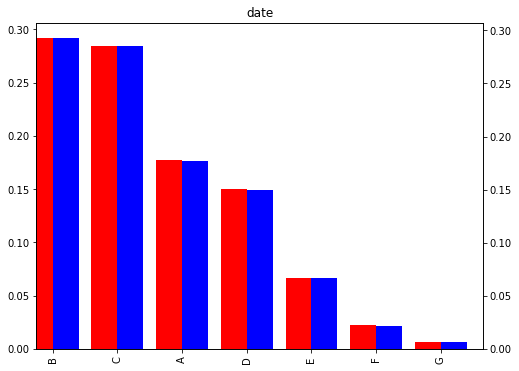

In [29]:
# check distribution
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4
X_train.grade.value_counts(normalize=True).plot(kind='bar', color='red', ax=ax, width=width, position=1)
X_test.grade.value_counts(normalize=True).plot(kind='bar', color='blue', ax=ax2,
width=width, position=0)
ax.set_title('date')
plt.show()

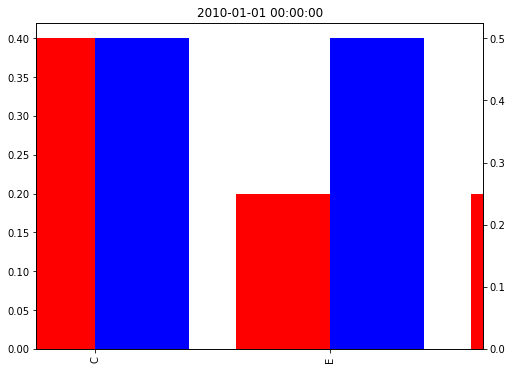

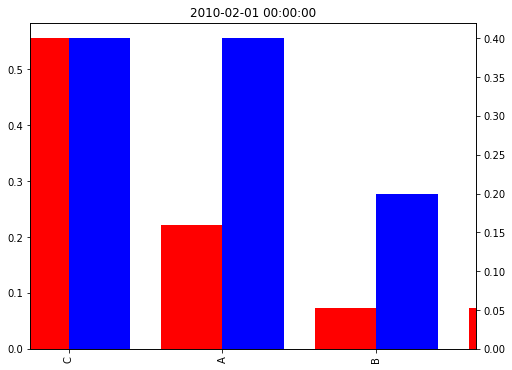

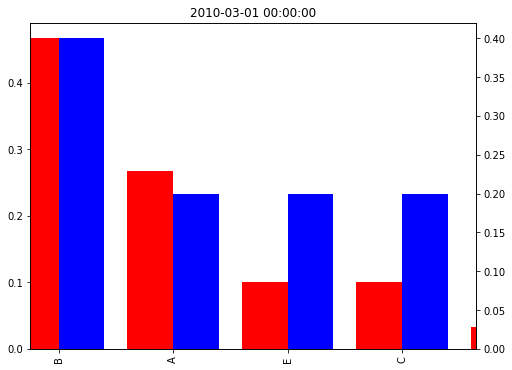

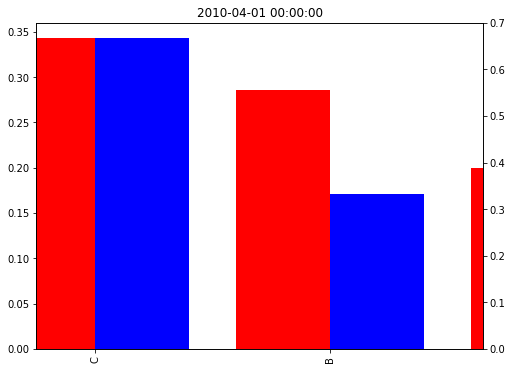

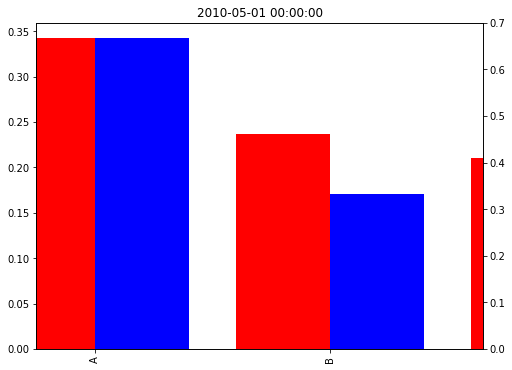

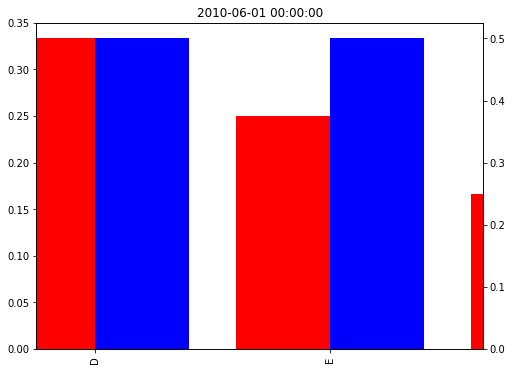

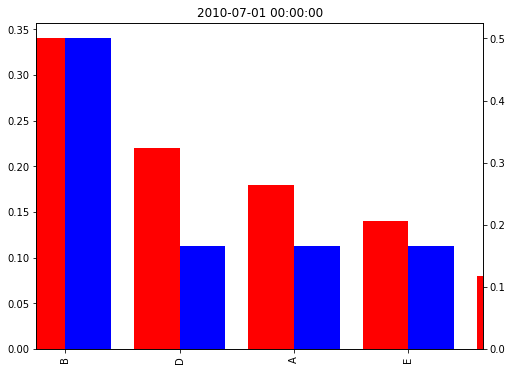

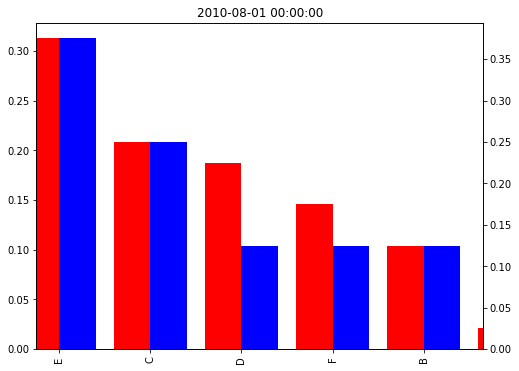

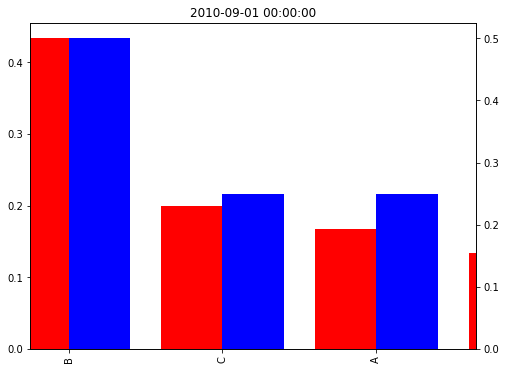

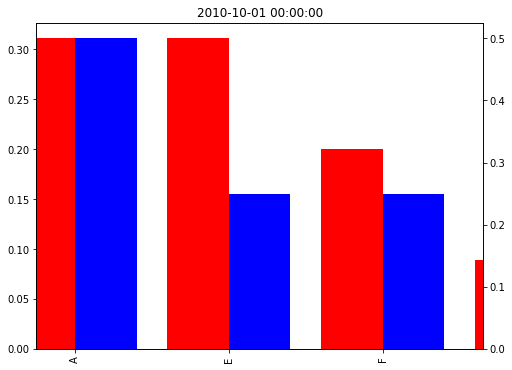

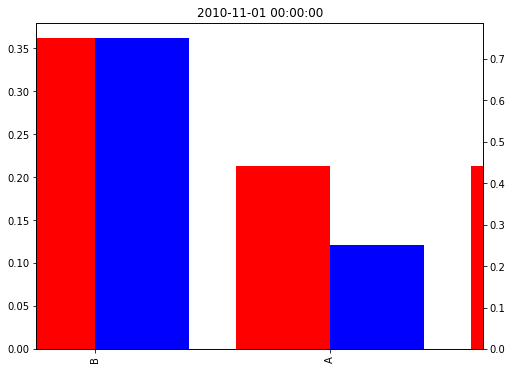

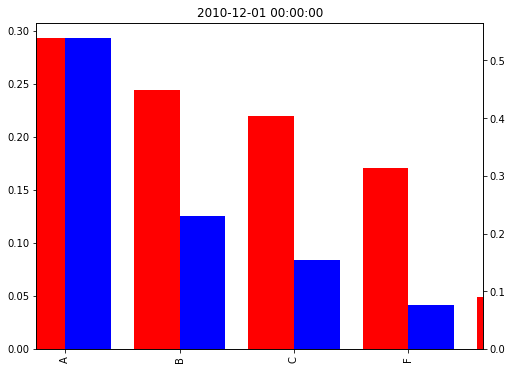

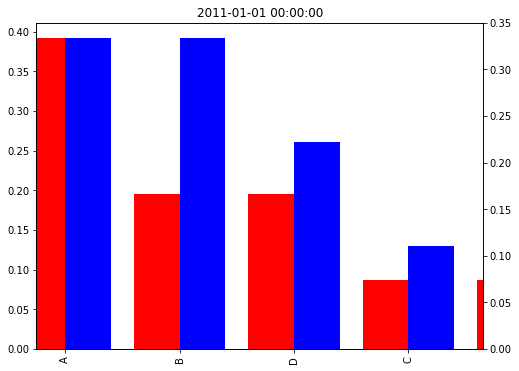

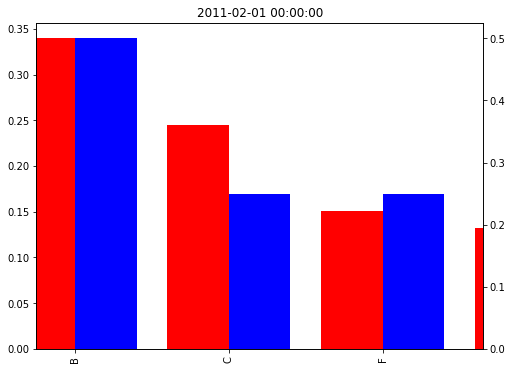

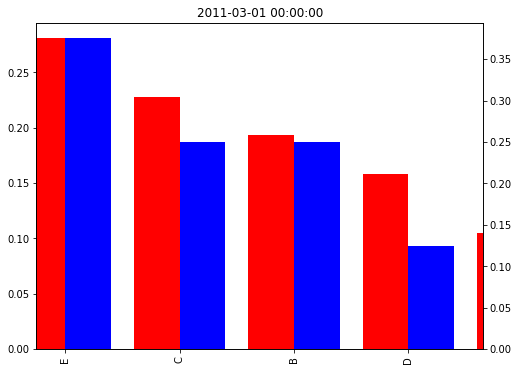

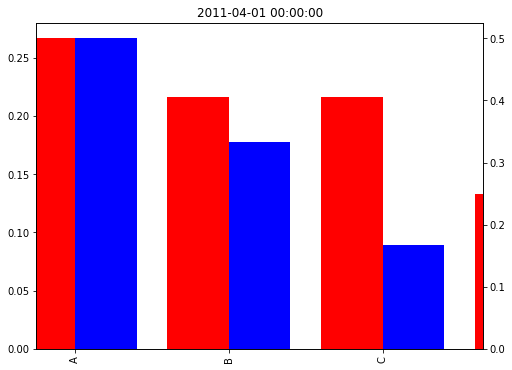

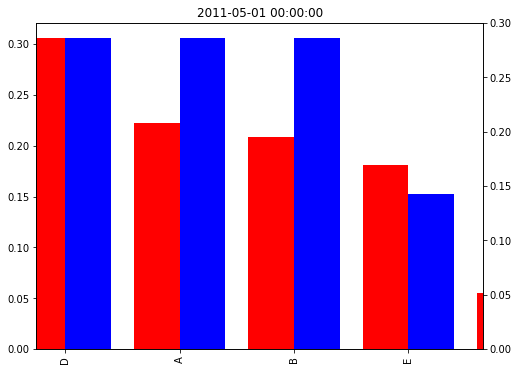

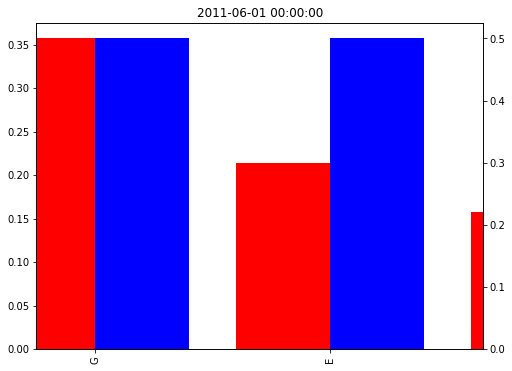

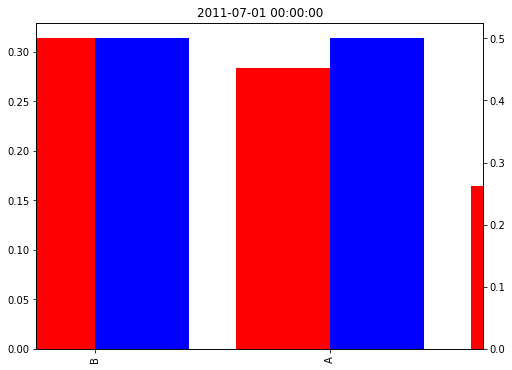

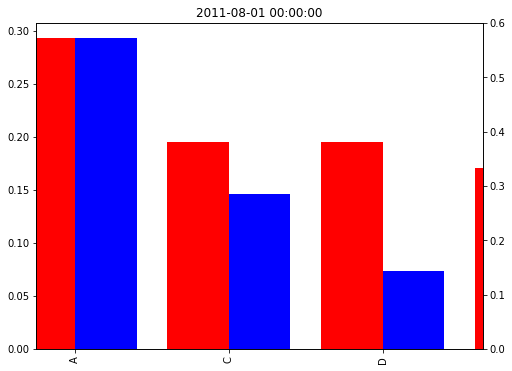

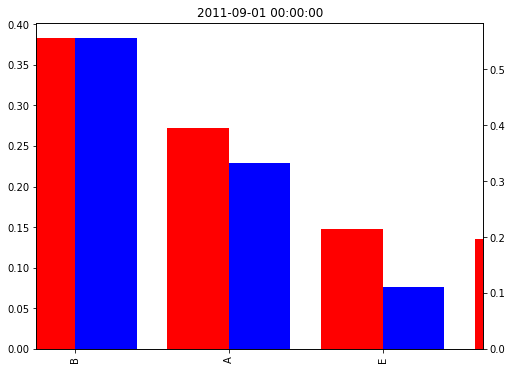

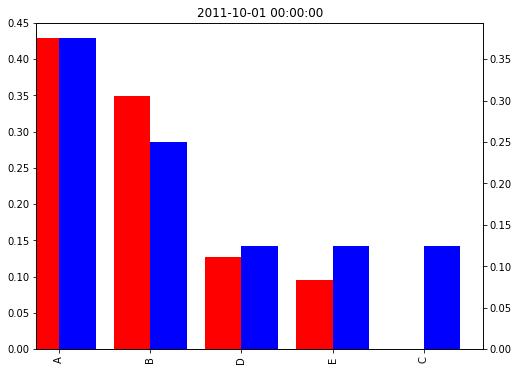

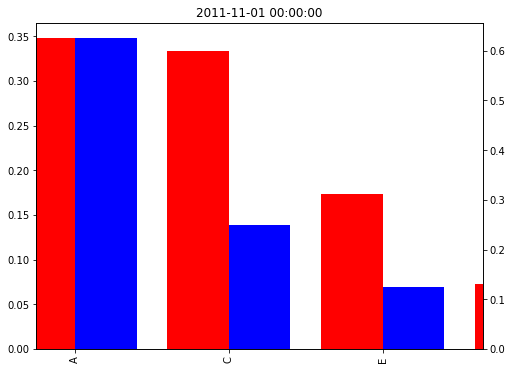

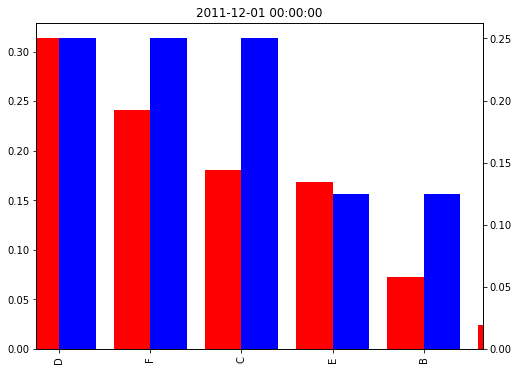

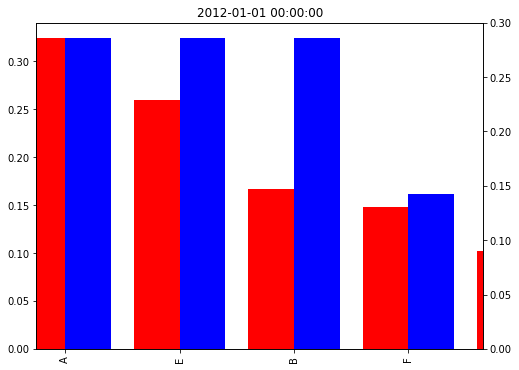

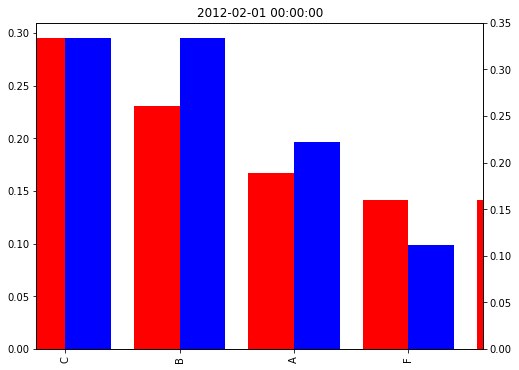

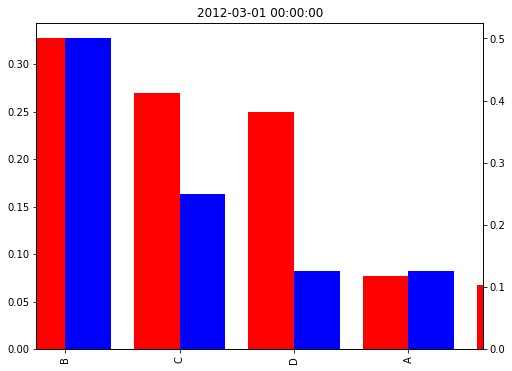

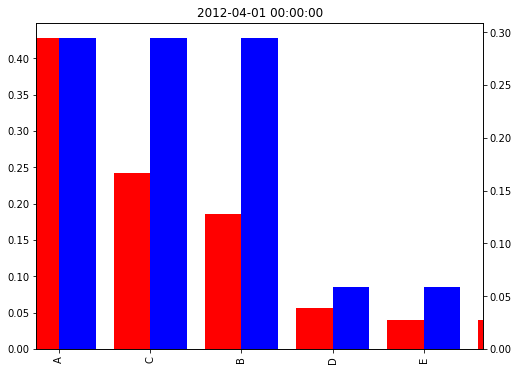

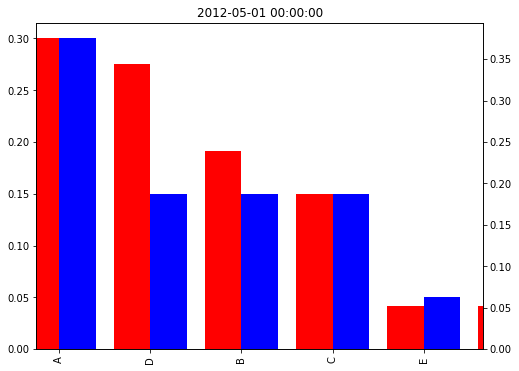

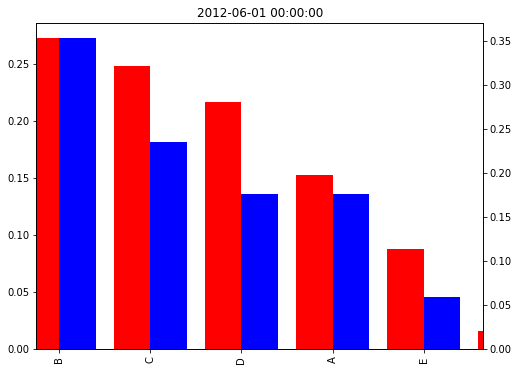

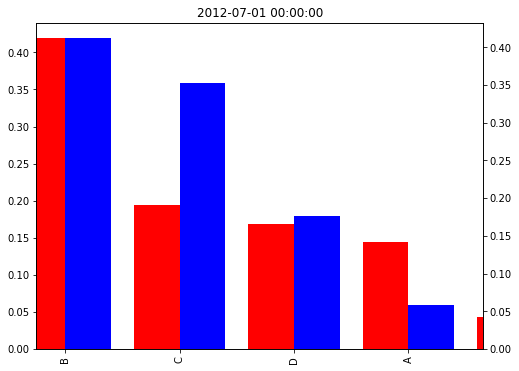

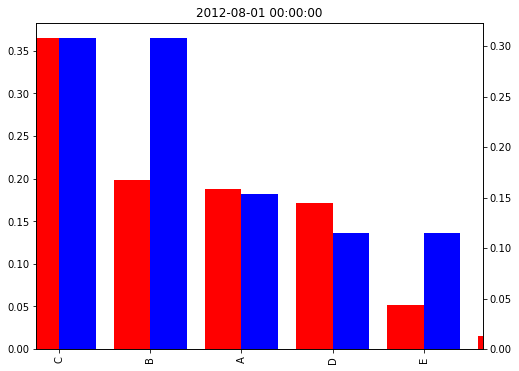

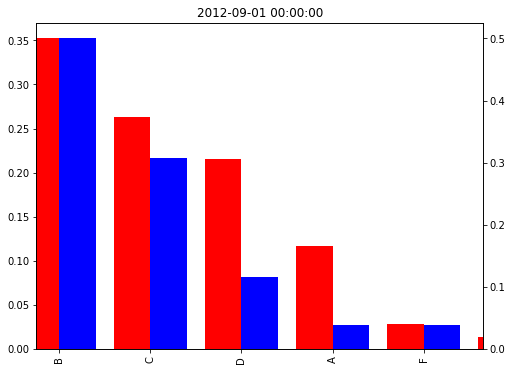

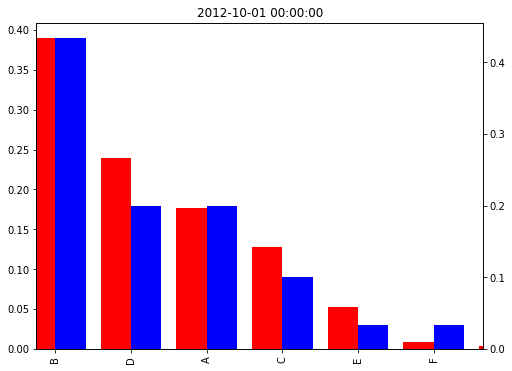

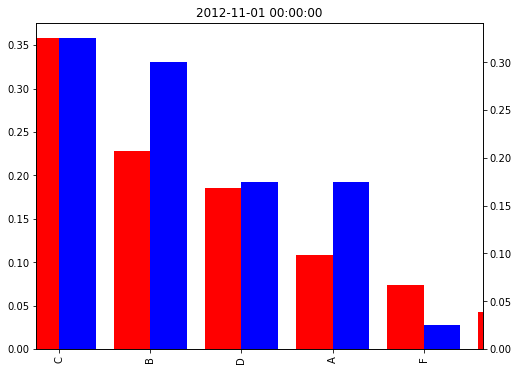

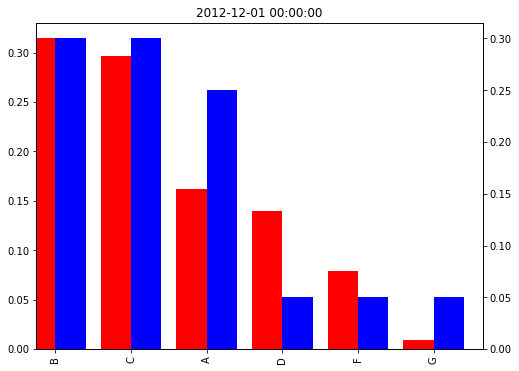

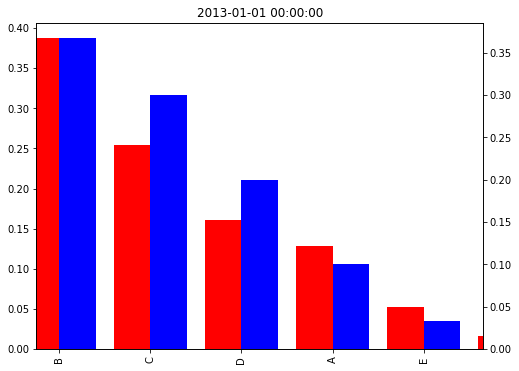

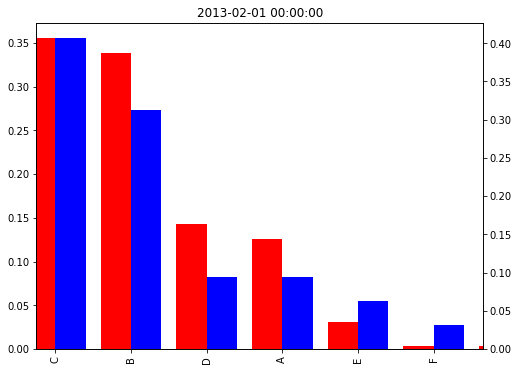

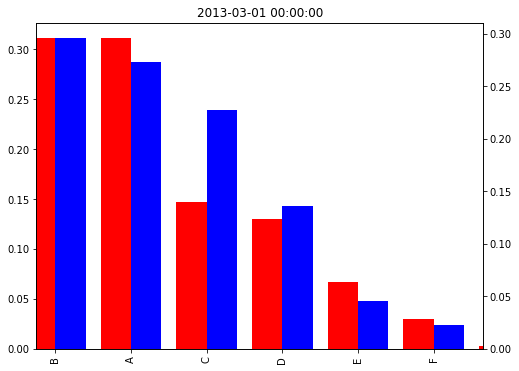

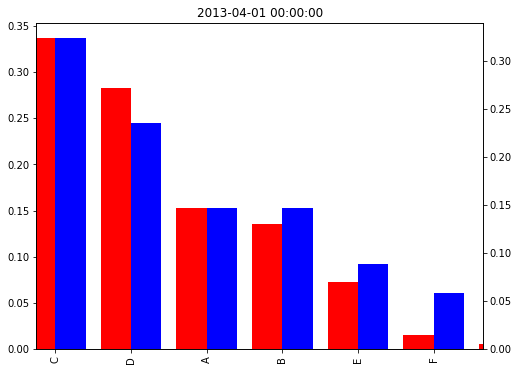

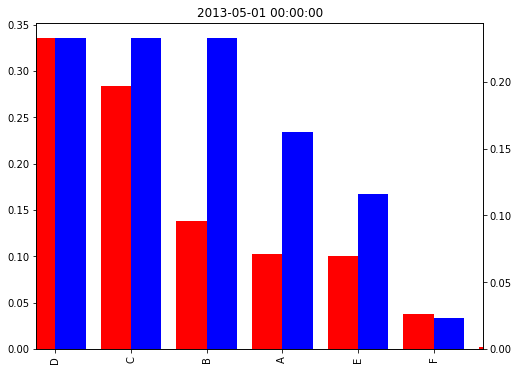

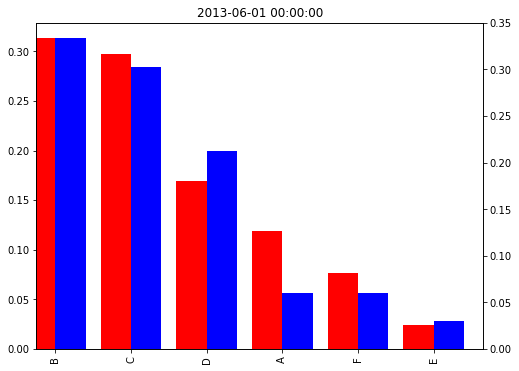

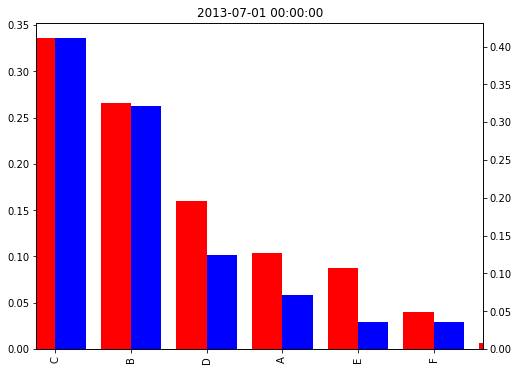

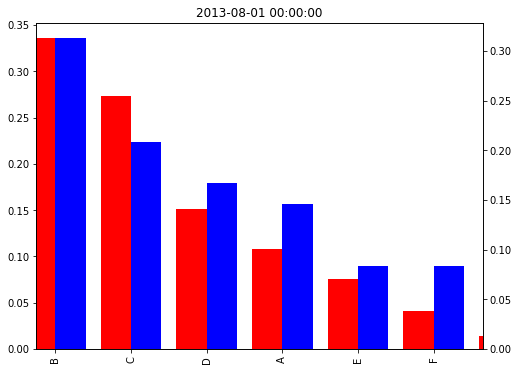

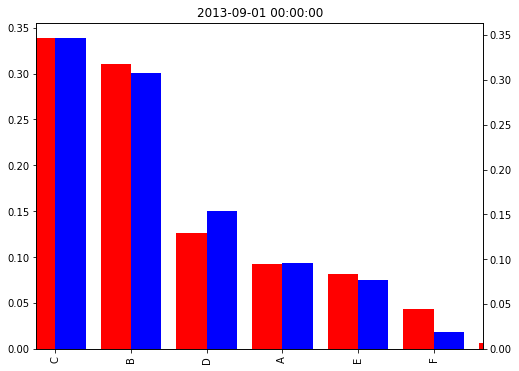

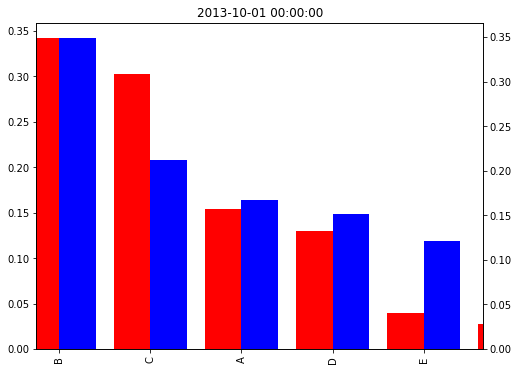

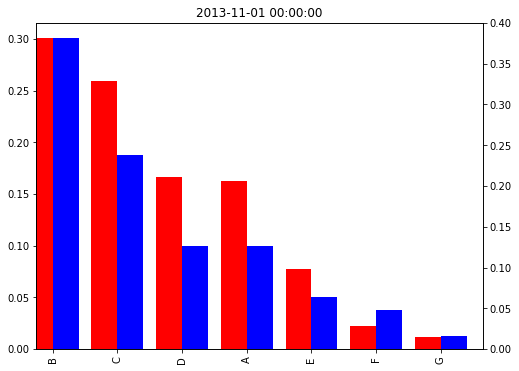

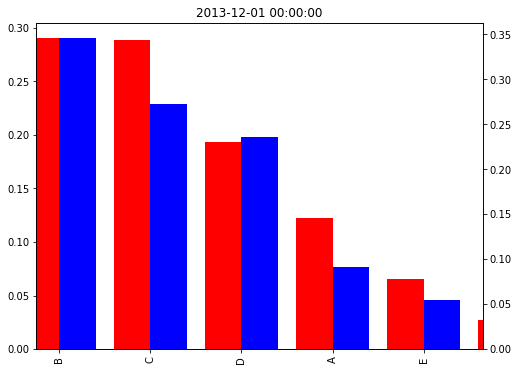

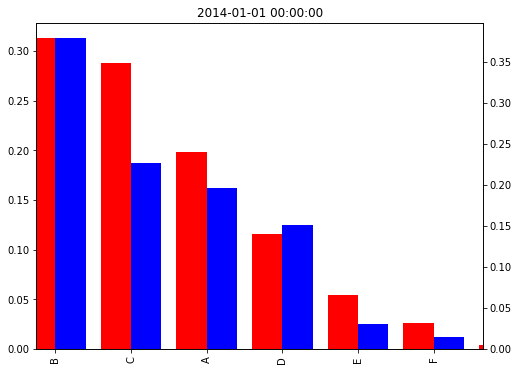

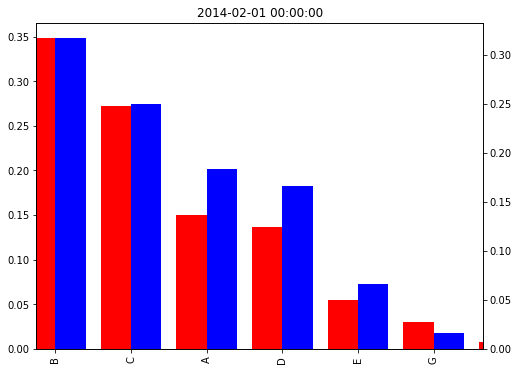

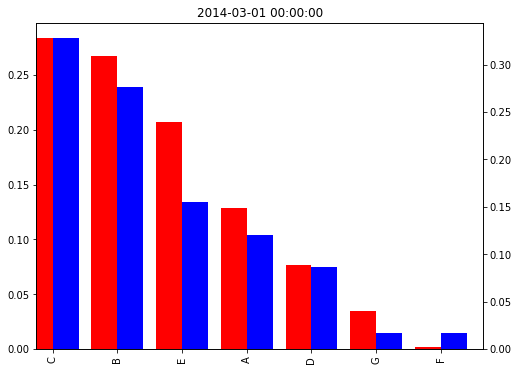

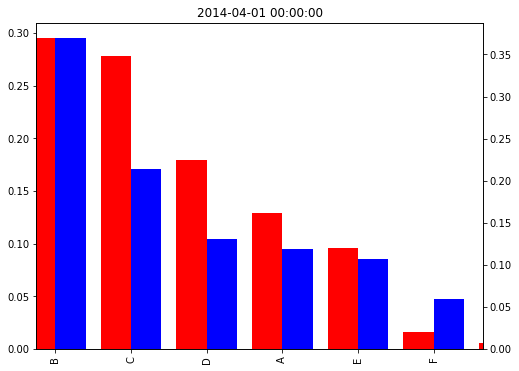

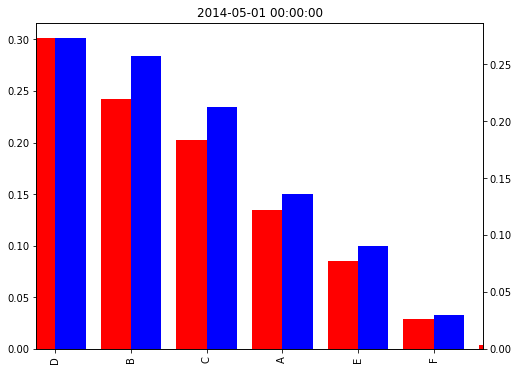

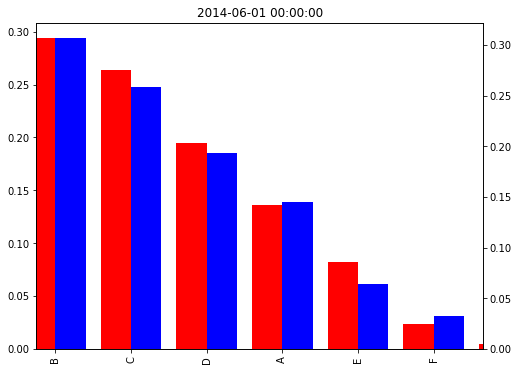

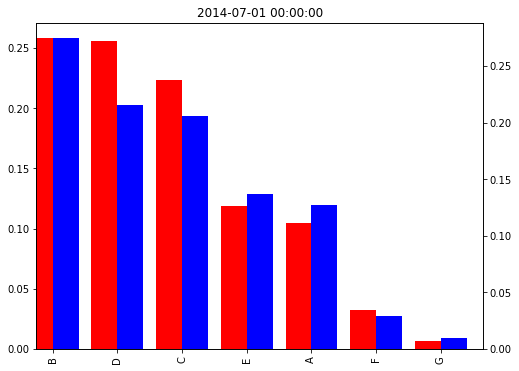

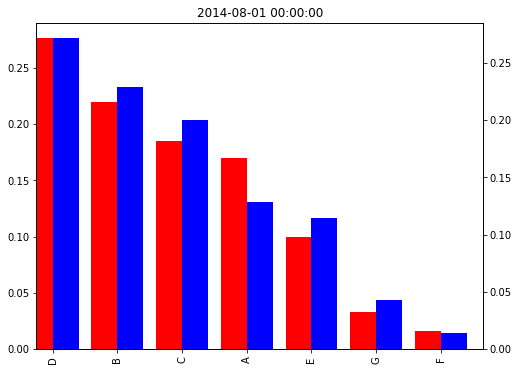

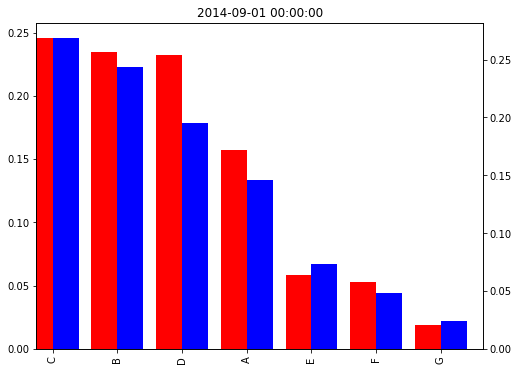

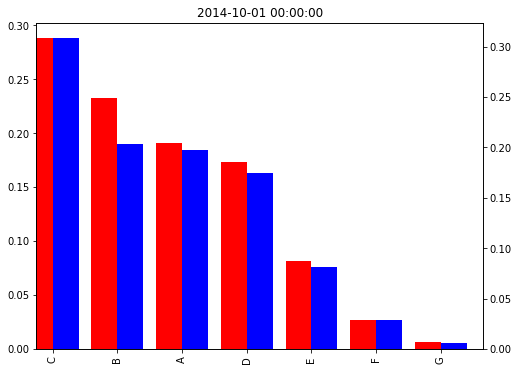

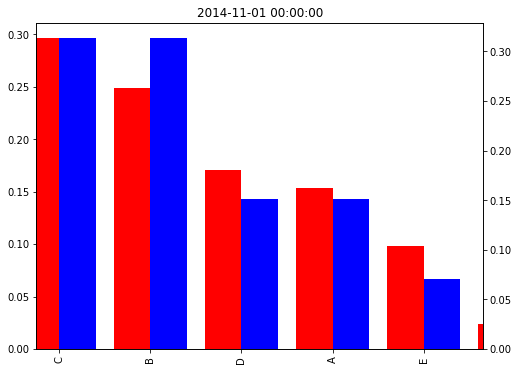

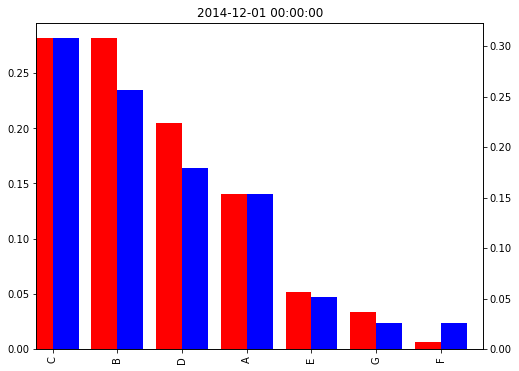

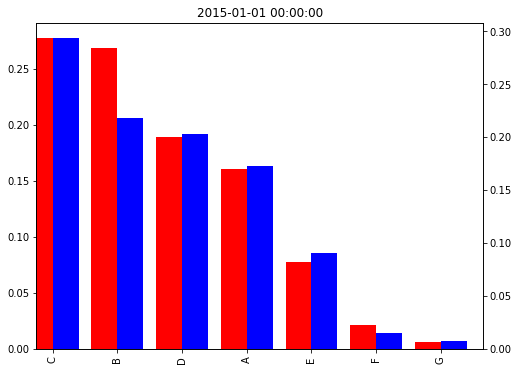

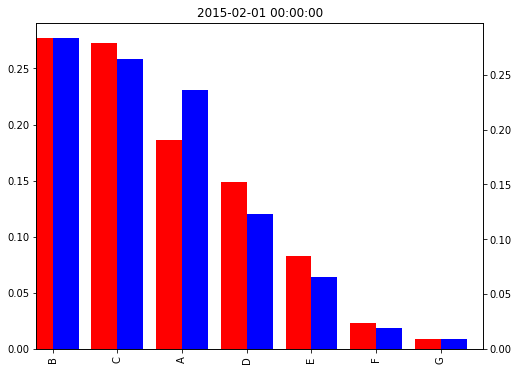

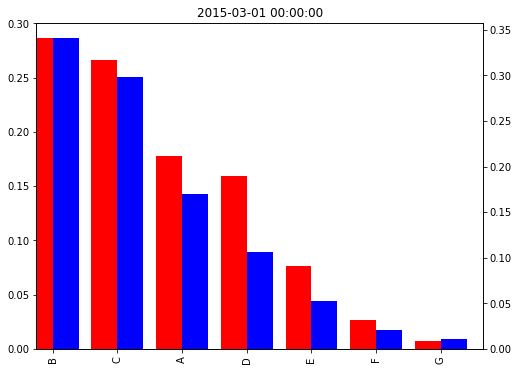

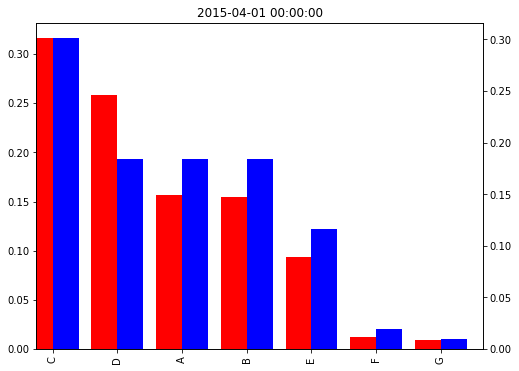

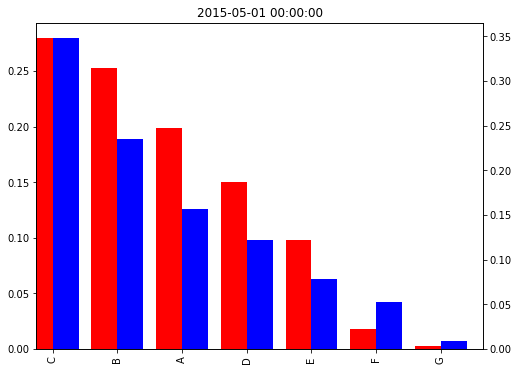

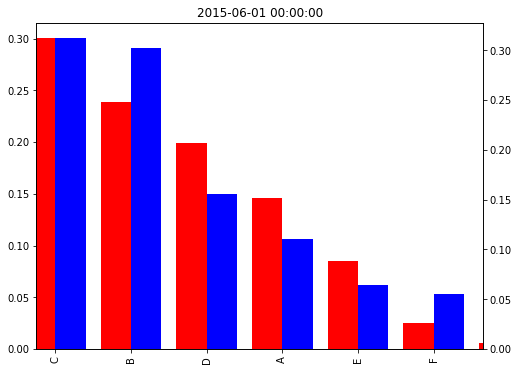

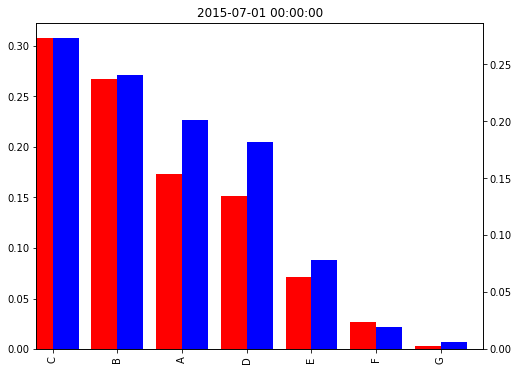

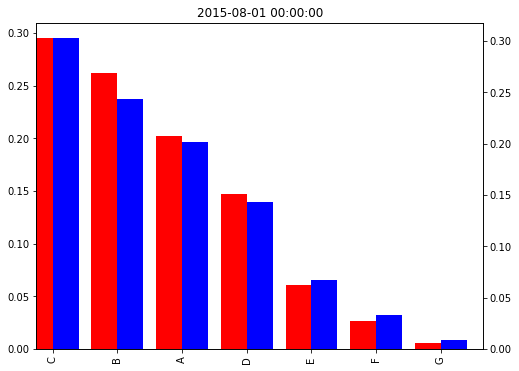

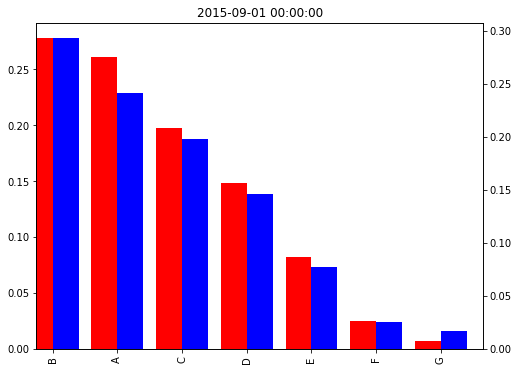

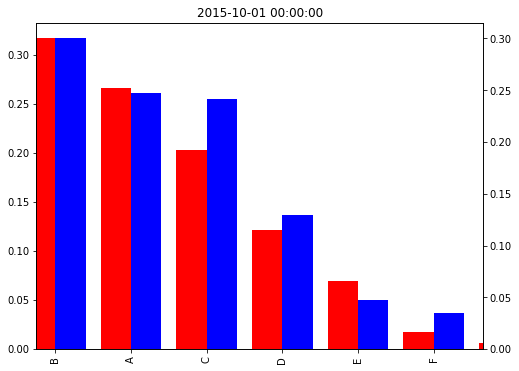

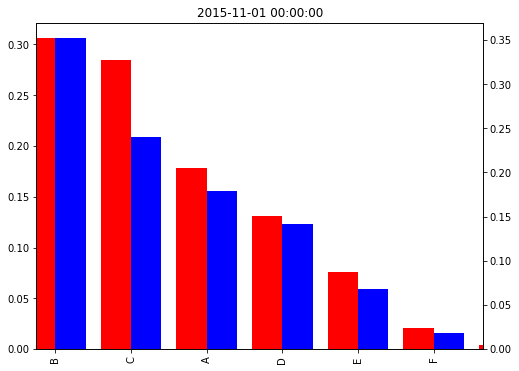

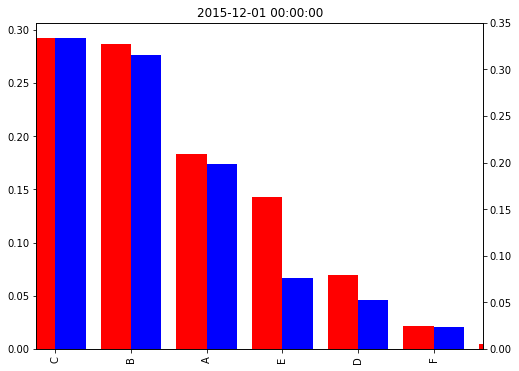

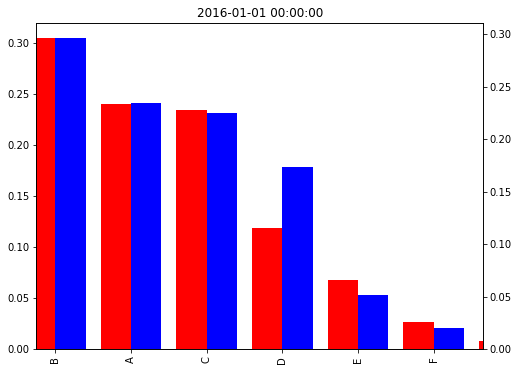

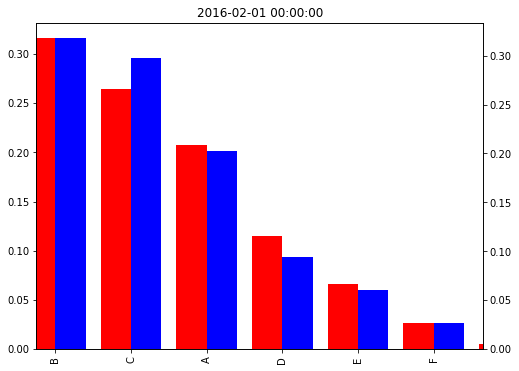

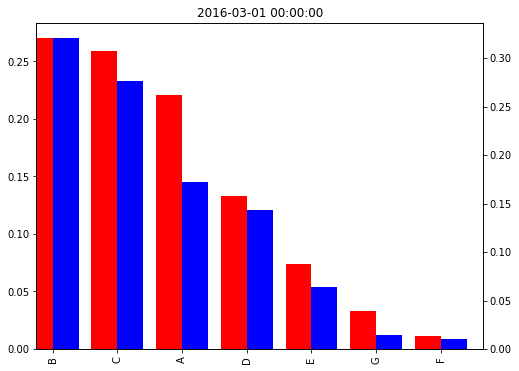

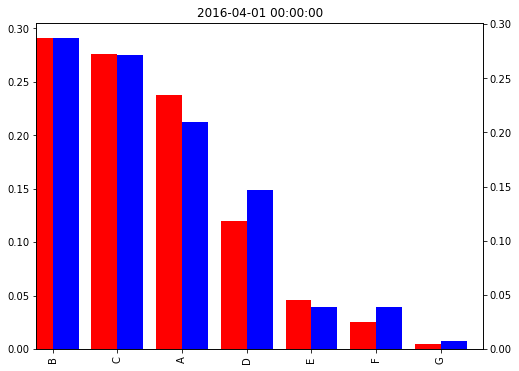

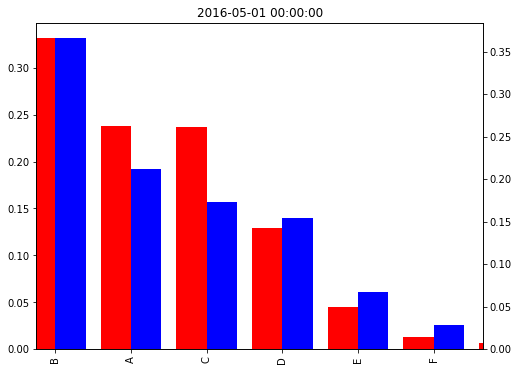

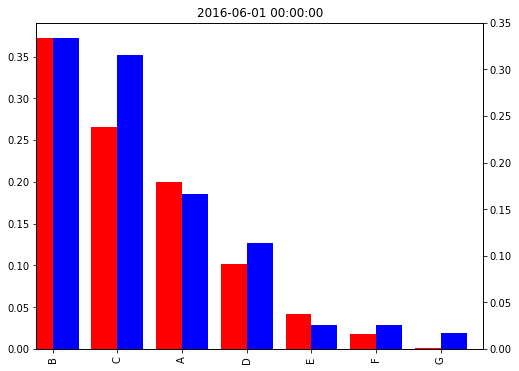

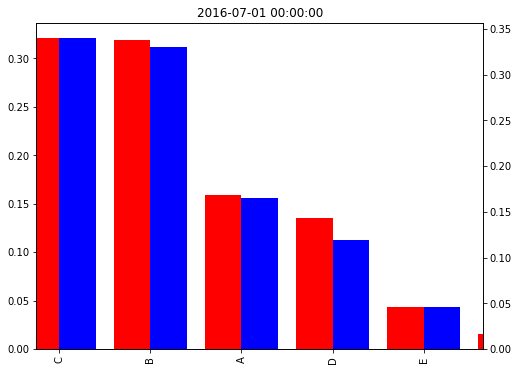

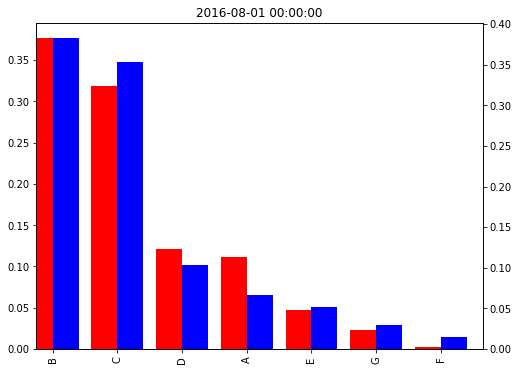

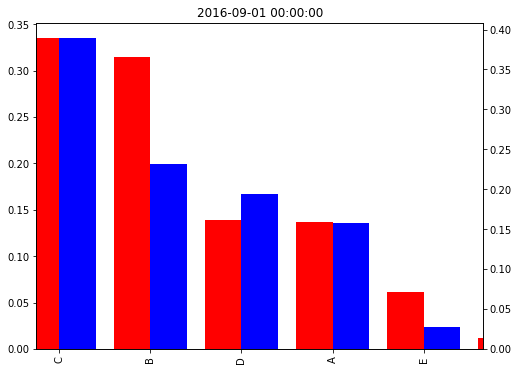

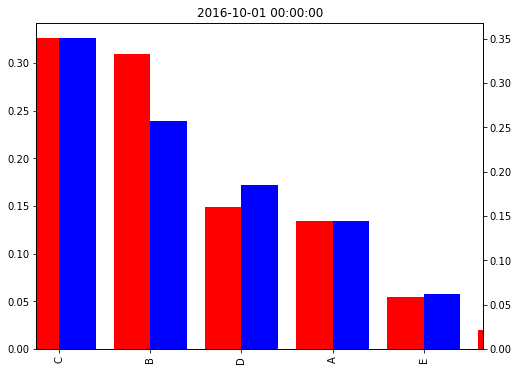

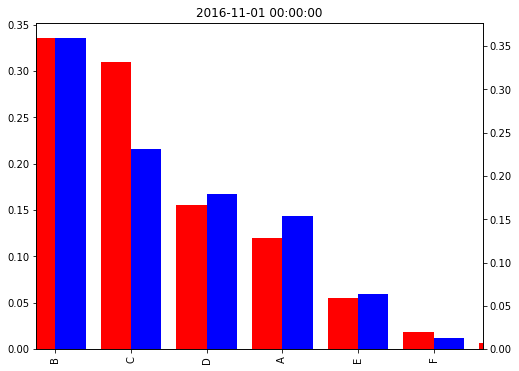

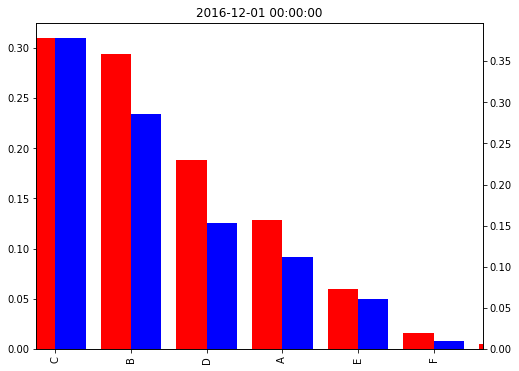

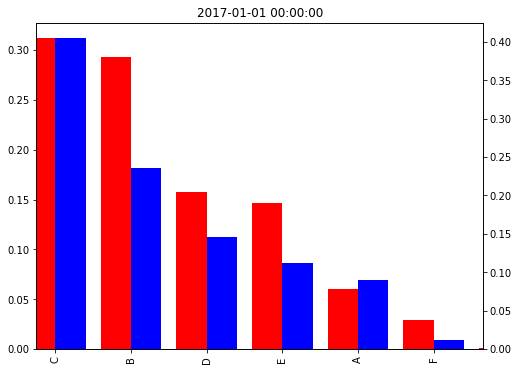

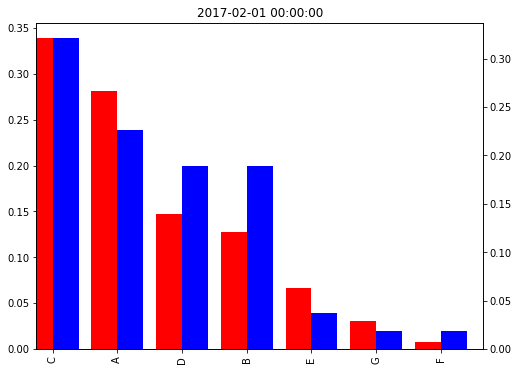

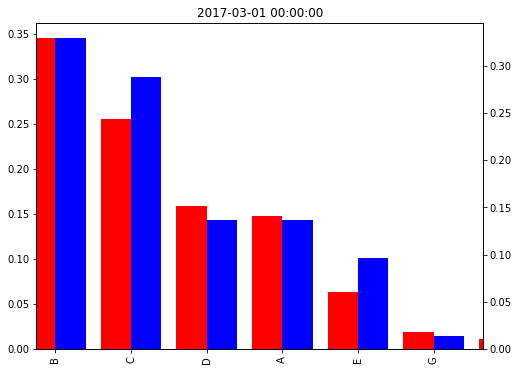

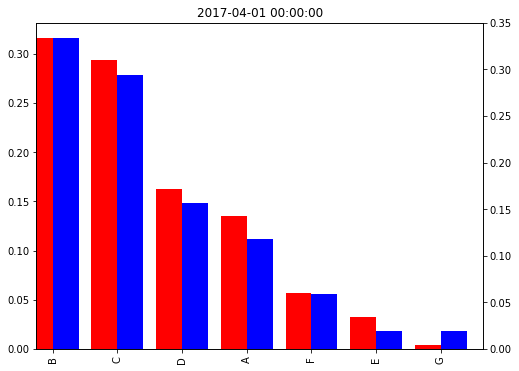

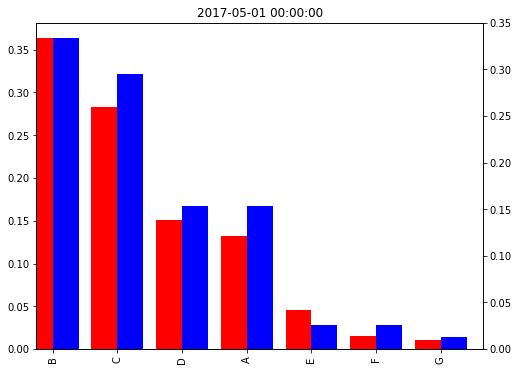

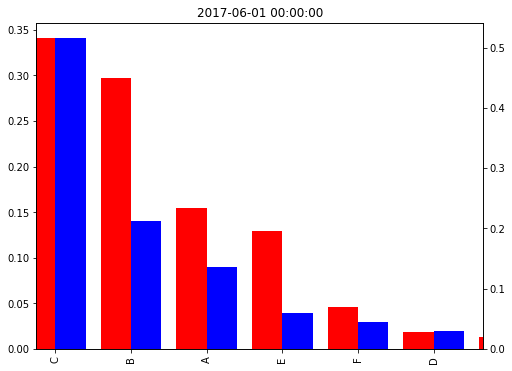

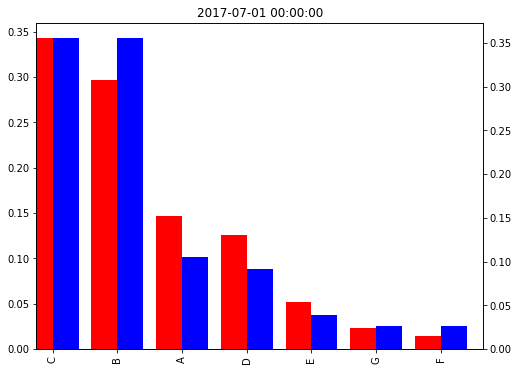

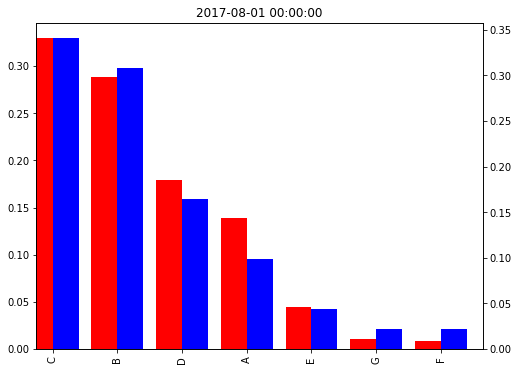

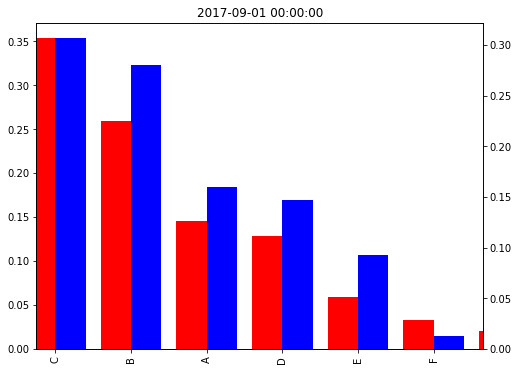

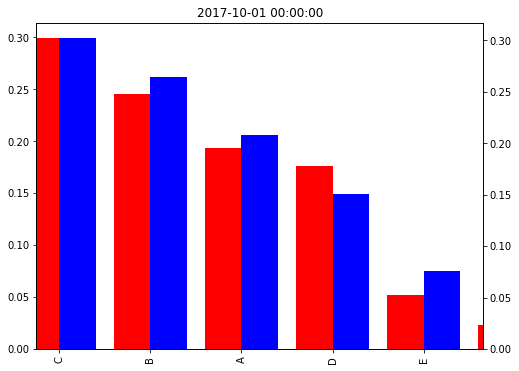

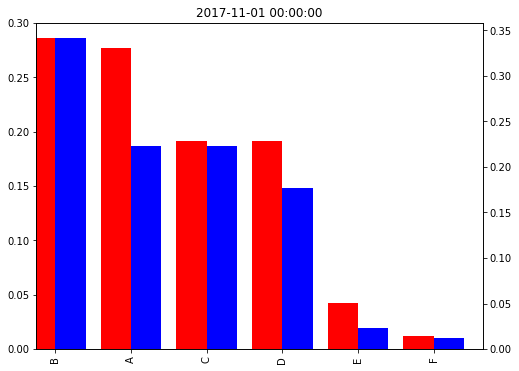

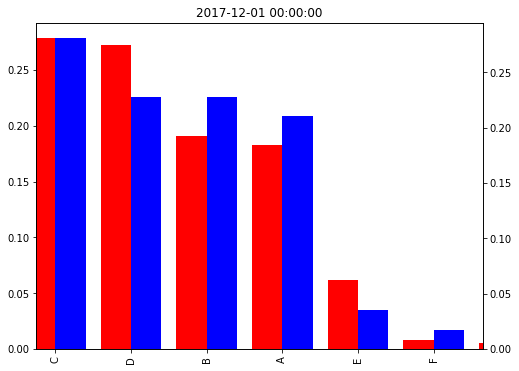

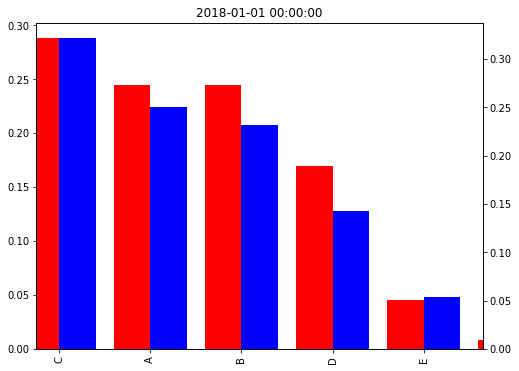

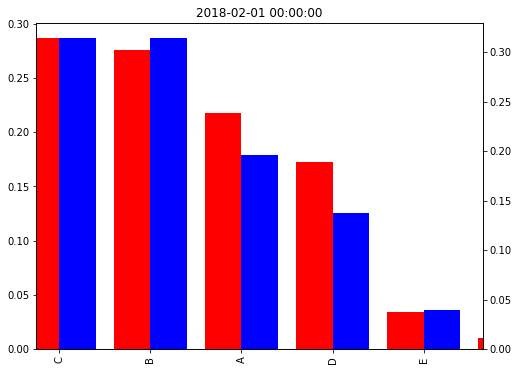

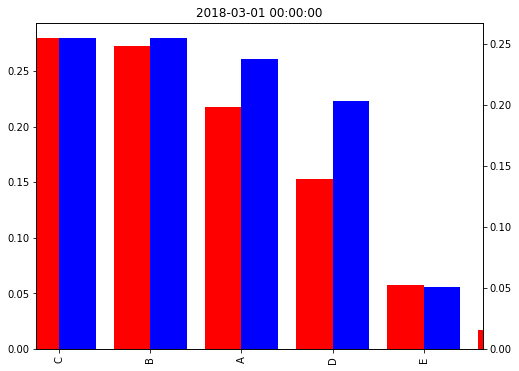

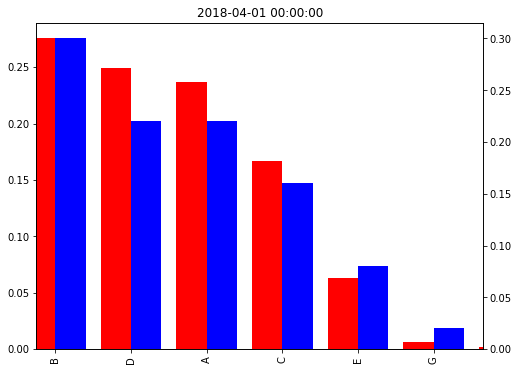

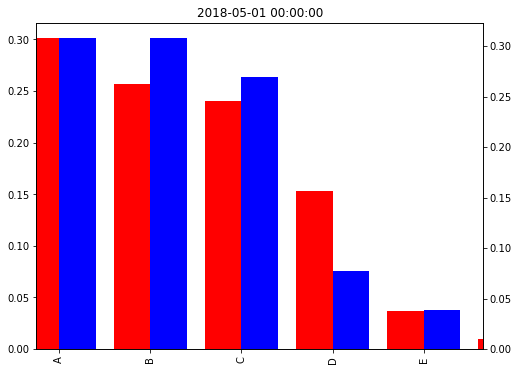

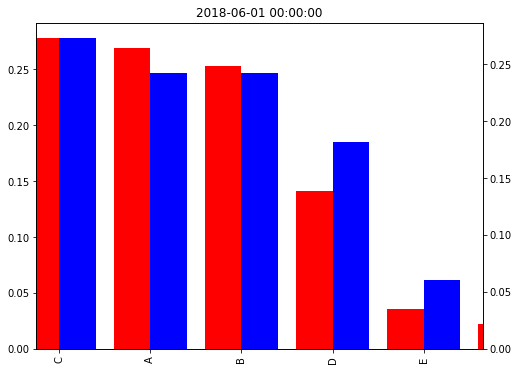

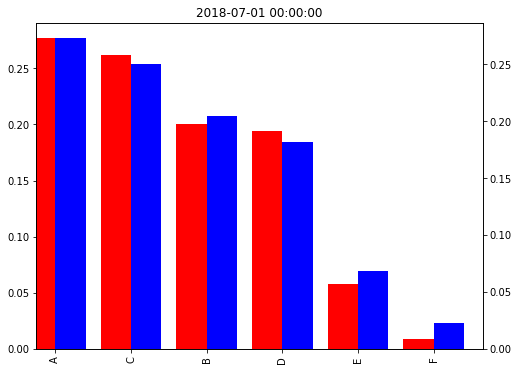

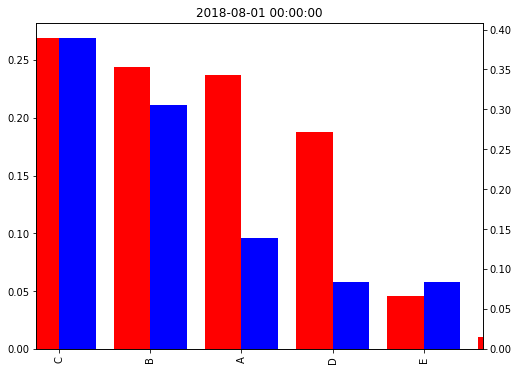

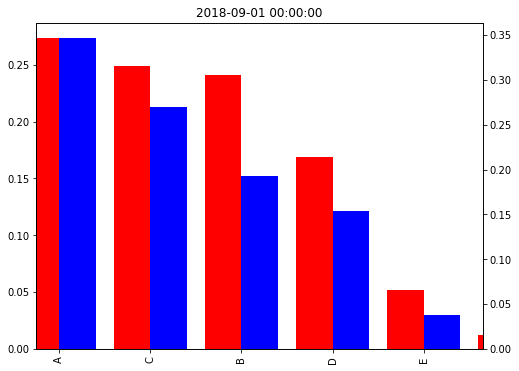

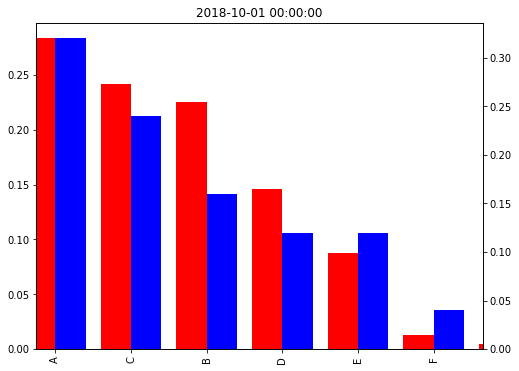

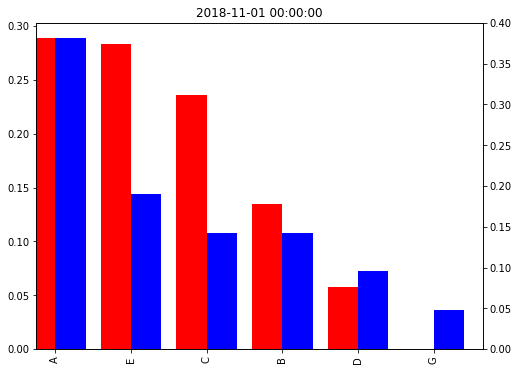

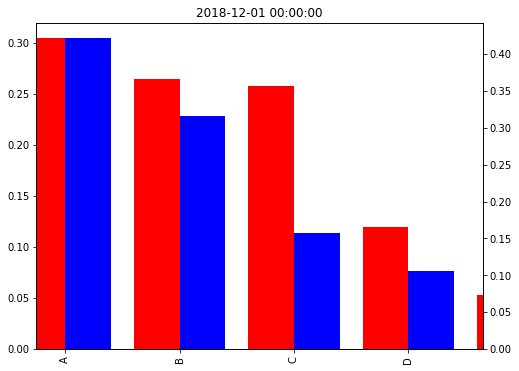

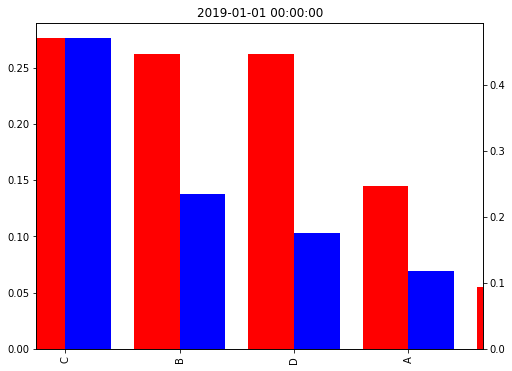

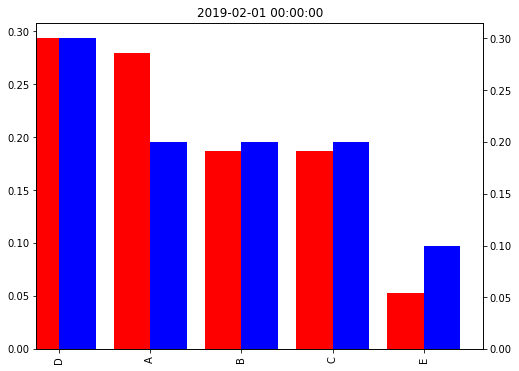

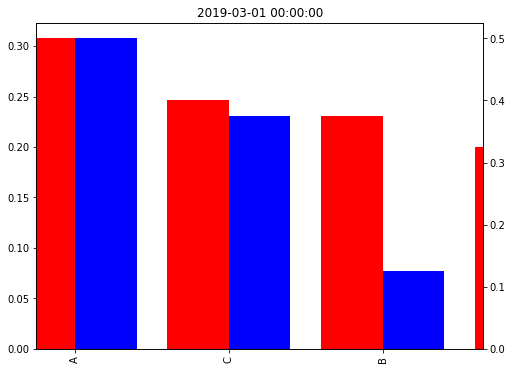

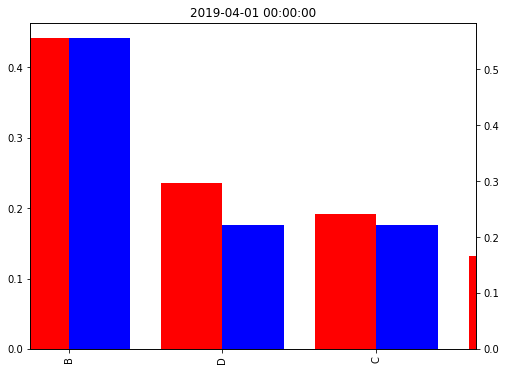

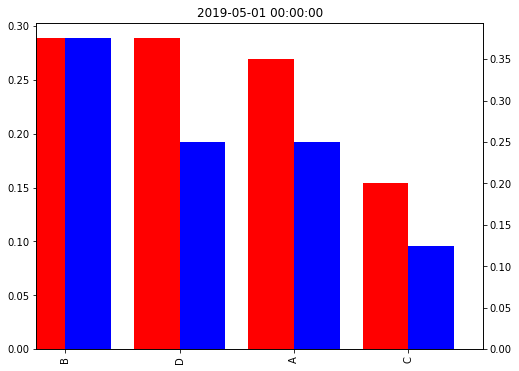

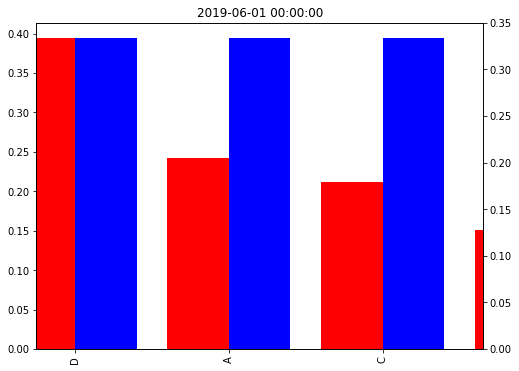

In [30]:
# check month by month distribution
issue_d_grouped = X_test.groupby('issue_d')
for issue_d, group in issue_d_grouped:
    train_g = X_train.query('issue_d == @issue_d')
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4
    train_g.grade.value_counts(normalize=True).plot(kind='bar', color='red', ax=ax, width=width, position=1)
    group.grade.value_counts(normalize=True).plot(kind='bar', color='blue', ax=ax2,
    width=width, position=0)
    ax.set_title(issue_d)
    plt.show()

In [425]:
X_train.shape

(2801, 47)

In [426]:
X_test.shape

(312, 47)

In [427]:
y_train.shape

(2801,)

In [428]:
y_train.shape

(2801,)

In [350]:


issue_d_g = train_testable_eval_loan_info.groupby('issue_d')
test_ids = []
check_cols = ['target_strict', 'grade']
for date, group in issue_d_g:
    if date >= pd.to_datetime('2010-1-1'):
        n_sample = min(int(len(group)*.1), 2000)
        print('sampling {0} for issue_d group {1}'.format(n_sample, date))
        samp = group.sample(n=min(int(len(group)*.1), 2000), random_state=42)
        if ctt.check_sample_distribution(group, samp, check_cols=check_cols, verbose=False):
            print()
        test_ids.extend(samp['id'].tolist())

sampling 0 for issue_d group 2010-02-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-03-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-04-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-05-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-06-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-07-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-08-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-09-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-10-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-11-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2010-12-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2011-01-01 00:00:00
There is a sampling concern
sampling 0 for issue_d group 2011-02-01 00:00:00
There is a sampling concern

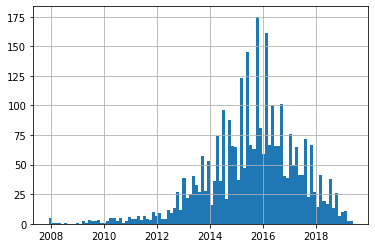

In [354]:
train_testable_eval_loan_info['issue_d'].hist(bins=100)

In [360]:
group = train_testable_eval_loan_info.query('issue_d > "2016-1-1" and issue_d < "2017-1-1"')
sample = group.sample(int(len(group)*.1))
print(group.shape, sample.shape)

(640, 47) (64, 47)


In [ ]:
def test_sampler(df, cols, pct=.1):
    '''
    given a df, 
    '''

In [366]:
x = [0] * 99
x += [1]

In [395]:
def sampling_exp(arr, pct, trials, replace):
    '''
    What percent of trials will have my object of interest (1% prevalence)
    when sample pct% of the data?
    '''
    n_sample = int(len(arr)*pct)
    res = 0
    for trial in tqdm(range(trials)):
        samp = np.random.choice(arr, size=n_sample, replace=replace)
        if 1 in samp:
            res += 1
    return res/trials

In [396]:
# sampling_exp(x, 1, 10000)

In [397]:
no_rep_res_dict = {}
rep_res_dict = {}
for i in np.arange(0, 1.01, .01):
    no_rep_res_dict[i] = sampling_exp(x, i, 10000, replace=False)
    rep_res_dict[i] = sampling_exp(x, i, 10000, replace=True)

100%|██████████| 10000/10000 [00:00<00:00, 24441.62it/s]


In [398]:
simple_sampling_df = pd.DataFrame({'replacement': rep_res_dict, 'no_replacement': no_rep_res_dict})

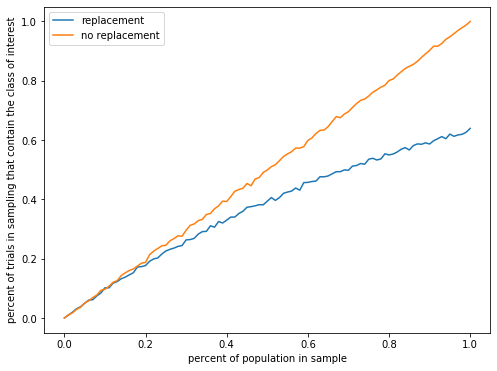

In [415]:
fig = plt.figure(figsize=(8,6))
plt.plot(simple_sampling_df['replacement'], label='replacement')
plt.plot(simple_sampling_df['no_replacement'], label='no replacement')
plt.xlabel('percent of population in sample')
plt.ylabel('percent of trials in sampling that contain the class of interest')
plt.legend()

In [363]:
%timeit len(group)

430 ns ± 1.65 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [364]:
%timeit group.shape[0]

672 ns ± 0.504 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [362]:
ctt.check_sample_distribution(group, sample, check_cols = ['grade', 'target_strict', 'int_rate'])

G group for grade column is missing entirely from the sample while population has 0.00625
0.12790000438690186 group for int_rate column is missing entirely from the sample while population has 0.028125
0.19990000128746033 group for int_rate column is missing entirely from the sample while population has 0.01875
0.08590000122785568 group for int_rate column is missing entirely from the sample while population has 0.0171875
0.0738999992609024 group for int_rate column is missing entirely from the sample while population has 0.0171875
0.17270000278949738 group for int_rate column is missing entirely from the sample while population has 0.015625
0.1559000015258789 group for int_rate column is missing entirely from the sample while population has 0.0140625
0.07890000194311142 group for int_rate column is missing entirely from the sample while population has 0.0140625
0.16990000009536743 group for int_rate column is missing entirely from the sample while population has 0.0140625
0.1825000047

In [348]:
group = np.arange(21000)
n_sample = min(int(len(group)*.1), 2000)

In [349]:
n_sample

2000

In [ ]:



# test_eval_loan_info = train_testable_eval_loan_info.query('id in @test_ids')
# # test_loan_info = train_testable_loan_info.query('id in @test_ids')

# train_eval_loan_info = train_testable_eval_loan_info.query('id not in @test_ids')
# # train_loan_info = train_testable_loan_info.query('id not in @test_ids')

# test_eval_loan_info.shape[0] + train_eval_loan_info.shape[0] == train_testable_eval_loan_info.shape[0]

# # if check_train_test_testable(train_eval_loan_info, test_eval_loan_info, train_testable_eval_loan_info,
# #                              train_loan_info, test_loan_info, train_testable_loan_info):


# train_test_ids_dict = {}
# train_test_ids_dict['train_testable'] = train_testable_ids.tolist()
# train_test_ids_dict['train'] = train_eval_loan_info['id'].tolist()
# train_test_ids_dict['test'] = test_eval_loan_info['id'].tolist()

# # make 10 bootstrap month-by-month test_loan_infos (and maybe test_eval_loan_infos?)
# bootstrap_sample_idx = {}
# issue_d_g = test_eval_loan_info.groupby('issue_d')
# for i in range(10):
#     to_concat = []
#     for d, g in issue_d_g:
#         to_concat.append(g.sample(len(g), replace=True))
#     df = pd.concat(to_concat)
#     bootstrap_sample_idx[i] = df.index.tolist()
    
# # # save
# # with open(os.path.join(dpath, 'train_test_ids.pkl'), 'wb') as file:
# #     pickle.dump(train_test_ids_dict, file)    
# # with open(os.path.join(dpath, 'bootstrap_test_idx.pkl'), 'wb') as file:
# #     pickle.dump(bootstrap_sample_idx, file)

